# **Q12. AdEase - Time Series**

## **Problem Statement:**
### 1. Help AdEase to forecast the number of views on wikipedia pages so that they can predict and optimize the ad placement for their clients.


In [67]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import (
    mean_squared_error as mse,
    mean_absolute_error as mae, 
    mean_absolute_percentage_error as mape
)
import pylab
import missingno as msno
import warnings
#from fbprophet import Prophet
warnings.filterwarnings("ignore")

In [68]:
pd.set_option('display.max_columns', None)
minmaxscaler = MinMaxScaler()
standardscaler = StandardScaler()
sns.set_theme(style="darkgrid")
continuous_types = ['float64', 'datetime64[ns]']
discrete_types = ['int64']
numeric_types = ['int64', 'float64']
categorical_types = ['category', 'bool']
get_columns_by_types = lambda df, types: [df.columns[index] for index in range(len(df.columns)) if df.dtypes[index].name in types]

***
***
## **1. Defining Helper Functions.**

In [69]:
def convert_to_best_type(df):
    for column in df.columns:
        try:
            if np.any(df[column].apply(lambda x: '.' in str(x))):
                df[column] = df[column].astype('float64')
            else:
                if np.any(df[column].apply(lambda x: str(x).lower()=='true' or str(x).lower()=='false')):
                    df[column] = df[column].astype(bool)
                elif len(df[column].unique())<10:
                    df[column] = pd.Categorical(df[column])
                else:
                    df[column] = df[column].astype('int64')
        except:
            if np.any(df[column].apply(lambda x: str(x).lower()=='true' or str(x).lower()=='false')):
                df[column] = df[column].astype(bool)
            elif np.any(df[column].apply(lambda x: ':' in str(x))):
                df[column] = pd.to_datetime(df[column])
            elif len(df[column].unique())<10:
                df[column] = pd.Categorical(df[column])
            else:
                df[column] = df[column].astype('string')
    return df

In [70]:
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    outlier_fraction = (len(df_in)-len(df_out))/len(df_in)
    if outlier_fraction > 0.0:
        fig, axes = plt.subplots(1, 1, sharex=True, figsize=(18,6))
        sns.boxplot(data=df_in, y=col_name)
        if outlier_fraction <= 0.10:
            fig.suptitle(f"Outliers constitute {round(outlier_fraction*100, 2)}% of data for column '{col_name}'. Hence removing outliers.", fontsize=20, color="green")
            plt.show()
            return df_out
        else:
            fig.suptitle(f"Outliers constitute significant amount of data ({round(outlier_fraction*100, 2)}%) for column '{col_name}'. Hence not removing outliers..", fontsize=20, color="green")
            plt.show()
            return df_in
    else:
        return df_in

In [71]:
def performance(actual, predicted):
    print('MAE :', round(mae(actual, predicted), 3))
    print('RMSE :', round(mse(actual, predicted)**0.5, 3)) 
    print('MAPE:', round(mape(actual, predicted), 3))

In [72]:
def grid_search_arima(df, column, p_range=1, d_range=1, q_range=1, days=30):
    pb = -1
    db = -1
    qb = -1
    mapeb = 1
    for p in range(p_range):
        for d in range(d_range):
            for q in range(q_range):
                try:
                    train_x = df.loc[df.index < df.index[-days]].copy()
                    test_x = df.loc[df.index >= df.index[-days]].copy()
                    model = SARIMAX(train_x[column].values, order=(p, d, q))
                    model = model.fit(disp=False)
                    test_x['pred'] = model.forecast(steps=days)
                    mape_score = mape(test_x[column], test_x['pred'])
                    if mape_score < mapeb:
                        mapeb = mape_score
                        pb = p
                        db = d
                        qb = q
                except:
                    pass
    return pb, db, qb, mapeb

In [73]:
def grid_search_sarima(df, column, p1=1, d1=1, q1=1, p_range=1, d_range=1, q_range=1, m_range=1, days=30):
    pb = -1
    db = -1
    qb = -1
    mb  = -1
    mapeb = 1
    for p in range(p_range):
        for d in range(d_range):
            for q in range(q_range):
                for m in range(m_range):
                    try:
                        train_x = df.loc[df.index < df.index[-days]].copy()
                        test_x = df.loc[df.index >= df.index[-days]].copy()
                        model = SARIMAX(train_x[column].values, order=(p1, d1, q1), seasonal_order=(p, d, q, m))
                        model = model.fit(disp=False)
                        test_x['pred'] = model.forecast(steps=days)
                        mape_score = mape(test_x[column], test_x['pred'])
                        if mape_score < mapeb:
                            mapeb = mape_score
                            pb = p
                            db = d
                            qb = q
                            mb = m
                    except:
                        pass
    return pb, db, qb, mb, mapeb

In [74]:
def plot_arima(df, column, days=30, p=1, d=1, q=1):
    train_x = df.loc[df.index < df.index[-days]].copy()
    test_x = df.loc[df.index >= df.index[-days]].copy()
    model = SARIMAX(train_x[column].values, order=(p, d, q))
    model = model.fit(disp=False)
    test_x['pred'] = model.forecast(steps=days)
    fig, ax = plt.subplots(figsize=(18, 6))
    sns.lineplot(x=test_x.index, y=test_x[column], color='blue', label='Original')
    sns.lineplot(x=test_x.index, y=test_x['pred'], color='red', label='Prediction')
    plt.legend()
    plt.title(f"\n{days} days ARIMA forecast for {column} column. Mape score: {round(mape(test_x[column], test_x['pred']), 3)}\n", fontsize=30, color="green")
    plt.show()

In [75]:
def plot_sarima(df, column, days=30, p=1, d=1, q=1, p2=1, d2=1, q2=1, m2=1):
    train_x = df.loc[df.index < df.index[-days]].copy()
    test_x = df.loc[df.index >= df.index[-days]].copy()
    model = SARIMAX(train_x[column].values, order=(p, d, q), seasonal_order= (p2, d2, q2, m2))
    model = model.fit(disp=False)
    test_x['pred'] = model.forecast(steps=days)
    fig, ax = plt.subplots(figsize=(18, 6))
    sns.lineplot(x=test_x.index, y=test_x[column], color='blue', label='Original')
    sns.lineplot(x=test_x.index, y=test_x['pred'], color='red', label='Prediction')
    plt.legend()
    plt.title(f"\n{days} days SARIMA forecast for {column} column. Mape score: {round(mape(test_x[column], test_x['pred']), 3)}\n", fontsize=30, color="green")
    plt.show()

In [76]:
def plot_sarimax(df, column, exog, days=30, p=1, d=1, q=1, p2=1, d2=1, q2=1, m2=1):
    train_x = df.loc[df.index < df.index[-days]].copy()
    train_exog = exog.loc[df.index < df.index[-days]].copy()
    test_x = df.loc[df.index >= df.index[-days]].copy()
    test_exog = exog.loc[df.index >= df.index[-days]].copy()
    model = SARIMAX(train_x[column].values, order=(p, d, q), seasonal_order= (p2, d2, q2, m2), exog = train_exog)
    model = model.fit(disp=False)
    test_x['pred'] = model.forecast(steps=days, exog=test_exog)
    fig, ax = plt.subplots(figsize=(18, 6))
    sns.lineplot(x=test_x.index, y=test_x[column], color='blue', label='Original')
    sns.lineplot(x=test_x.index, y=test_x['pred'], color='red', label='Prediction')
    plt.legend()
    plt.title(f"\n{days} days SARIMAX forecast for {column} column. Mape score: {round(mape(test_x[column], test_x['pred']), 3)}\n", fontsize=30, color="green")
    plt.show()

***
***
## **2. Analyzing Basic Metrics.**

In [77]:
filename = 'train_1.csv'
df = pd.read_csv(filename)
#df = convert_to_best_type(df)

In [78]:
print("Shape:", df.shape, "\n")

Shape: (145063, 551) 



In [79]:
df.head()

Page  2015-07-01  2015-07-02  \
0            2NE1_zh.wikipedia.org_all-access_spider        18.0        11.0   
1             2PM_zh.wikipedia.org_all-access_spider        11.0        14.0   
2              3C_zh.wikipedia.org_all-access_spider         1.0         0.0   
3         4minute_zh.wikipedia.org_all-access_spider        35.0        13.0   
4  52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...         NaN         NaN   

   2015-07-03  2015-07-04  2015-07-05  2015-07-06  2015-07-07  2015-07-08  \
0         5.0        13.0        14.0         9.0         9.0        22.0   
1        15.0        18.0        11.0        13.0        22.0        11.0   
2         1.0         1.0         0.0         4.0         0.0         3.0   
3        10.0        94.0         4.0        26.0        14.0         9.0   
4         NaN         NaN         NaN         NaN         NaN         NaN   

   2015-07-09  2015-07-10  2015-07-11  2015-07-12  2015-07-13  2015-07-14  \
0        26.0        24.0        19.0        10.0        14.0        15.0   
1        10.0         4.0        41.0        65.0        57.0        38.0   
2         4.0         4.0         1.0         1.0         1.0         6.0   
3        11.0        16.0        16.0        11.0        23.0       145.0   
4         NaN         NaN         NaN         NaN         NaN         NaN   

   2015-07-15  2015-07-16  2015-07-17  2015-07-18  2015-07-19  2015-07-20  \
0         8.0        16.0         8.0         8.0        16.0         7.0   
1        20.0        62.0        44.0        15.0        10.0        47.0   
2         8.0         6.0         4.0         5.0         1.0         2.0   
3        14.0        17.0        85.0         4.0        30.0        22.0   
4         NaN         NaN         NaN         NaN         NaN         NaN   

   2015-07-21  2015-07-22  2015-07-23  2015-07-24  2015-07-25  2015-07-26  \
0        11.0        10.0        20.0        18.0        15.0        14.0   
1        24.0        17.0        22.0         9.0        39.0        13.0   
2         3.0         8.0         8.0         6.0         6.0         2.0   
3         9.0        10.0        11.0         7.0         7.0        11.0   
4         NaN         NaN         NaN         NaN         NaN         NaN   

   2015-07-27  2015-07-28  2015-07-29  2015-07-30  2015-07-31  2015-08-01  \
0        49.0        10.0        16.0        18.0         8.0         5.0   
1        11.0        12.0        21.0        19.0         9.0        15.0   
2         2.0         3.0         2.0         4.0         3.0         3.0   
3         9.0        11.0        44.0         8.0        14.0        19.0   
4         NaN         NaN         NaN         NaN         NaN         NaN   

   2015-08-02  2015-08-03  2015-08-04  2015-08-05  2015-08-06  2015-08-07  \
0         9.0         7.0        13.0         9.0         7.0         4.0   
1        33.0         8.0         8.0         7.0        13.0         2.0   
2         5.0         3.0         5.0         4.0         2.0         5.0   
3        10.0        17.0        17.0        10.0         7.0        10.0   
4         NaN         NaN         NaN         NaN         NaN         NaN   

   2015-08-08  2015-08-09  2015-08-10  2015-08-11  2015-08-12  2015-08-13  \
0        11.0        10.0         5.0         9.0         9.0         9.0   
1        23.0        12.0        27.0        27.0        36.0        23.0   
2         1.0         4.0         5.0         0.0         0.0         7.0   
3         1.0         8.0        27.0        19.0        16.0         2.0   
4         NaN         NaN         NaN         NaN         NaN         NaN   

   2015-08-14  2015-08-15  2015-08-16  2015-08-17  2015-08-18  2015-08-19  \
0         9.0        13.0         4.0        15.0        25.0         9.0   
1        58.0        80.0        60.0        69.0        42.0       161.0   
2         3.0         5.0         1.0         6.0         2.0         5.0   
3        84.0     

In [80]:
filename = 'Exog_Campaign_eng'
exog_df = pd.read_csv(filename)
#df = convert_to_best_type(df)

In [81]:
exog_df.head()

Exog
0     0
1     0
2     0
3     0
4     0

In [82]:
print("Shape:", exog_df.shape, "\n")

Shape: (550, 1) 



***
***
## **3. Feature Engineering - Create new fields from Page column.**

In [83]:
df['language'] = df['Page'].str.extract('_([^_|\.]+)\.(?:wikipedia|wikimedia|mediawiki)')[0]
df.loc[df['language']=='commons','language'] = 'wikimedia'
df.loc[df['language']=='www','language'] = 'mediawiki'

In [84]:
df['language'].value_counts()

en           24111
ja           20431
de           18547
fr           17802
zh           17229
ru           15022
es           14069
wikimedia    10552
mediawiki     7300
Name: language, dtype: int64

In [85]:
df['title'] = df['Page'].str.extract('([^\~]+)_[^_|\.]+\.(?:wikipedia|wikimedia|mediawiki)')[0]

In [86]:
df['access_type'] = df['Page'].str.extract('org_([^\.]+)_')[0]
df.loc[~df['access_type'].isin(['all-access', 'mobile-web', 'desktop']), 'access_type'] = 'Other'

In [87]:
df['access_type'].value_counts()

all-access    74292
mobile-web    35933
desktop       34794
Other            44
Name: access_type, dtype: int64

In [88]:
df['access_origin'] = df['Page'].str.extract('_([^_]+)$')[0]

In [89]:
df['access_origin'].value_counts()

all-agents    110150
spider         34913
Name: access_origin, dtype: int64

***
***
## **4. Missing Values - Analysis and Treatment.**

In [90]:
df[df.isna().any(axis=1)].shape[0]/df.shape[0]

0.19154436348345202

In [91]:
df[df.isna().any(axis=1)]

Page  2015-07-01  \
4       52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...         NaN   
6               91Days_zh.wikipedia.org_all-access_spider         NaN   
10               ASTRO_zh.wikipedia.org_all-access_spider         NaN   
13             AlphaGo_zh.wikipedia.org_all-access_spider         NaN   
19           B-PROJECT_zh.wikipedia.org_all-access_spider         NaN   
...                                                   ...         ...   
145058  Underworld_(serie_de_películas)_es.wikipedia.o...         NaN   
145059  Resident_Evil:_Capítulo_Final_es.wikipedia.org...         NaN   
145060  Enamorándome_de_Ramón_es.wikipedia.org_all-acc...         NaN   
145061  Hasta_el_último_hombre_es.wikipedia.org_all-ac...         NaN   
145062  Francisco_el_matemático_(serie_de_televisión_d...         NaN   

        2015-07-02  2015-07-03  2015-07-04  2015-07-05  2015-07-06  \
4              NaN         NaN         NaN         NaN         NaN   
6              NaN         NaN         NaN         NaN         NaN   
10             NaN         NaN         NaN         NaN         1.0   
13             NaN         NaN         NaN         NaN         NaN   
19             NaN         NaN         NaN         NaN         NaN   
...            ...         ...         ...         ...         ...   
145058         NaN         NaN         NaN         NaN         NaN   
145059         NaN         NaN         NaN         NaN         NaN   
145060         NaN         NaN         NaN         NaN         NaN   
145061         NaN         NaN         NaN         NaN         NaN   
145062         NaN         NaN         NaN         NaN         NaN   

        2015-07-07  2015-07-08  2015-07-09  2015-07-10  2015-07-11  \
4              NaN         NaN         NaN         NaN         NaN   
6              NaN         NaN         NaN         NaN         NaN   
10             1.0         NaN         NaN         NaN         NaN   
13             NaN         NaN         NaN         NaN         NaN   
19             NaN         NaN         NaN         NaN         NaN   
...            ...         ...         ...         ...         ...   
145058         NaN         NaN         NaN         NaN         NaN   
145059         NaN         NaN         NaN         NaN         NaN   
145060         NaN         NaN         NaN         NaN         NaN   
145061         NaN         NaN         NaN         NaN         NaN   
145062         NaN         NaN         NaN         NaN         NaN   

        2015-07-12  2015-07-13  2015-07-14  2015-07-15  2015-07-16  \
4              NaN         NaN         NaN         NaN         NaN   
6              NaN         NaN         NaN         NaN         NaN   
10             NaN         NaN         1.0         NaN         NaN   
13             NaN         NaN         NaN         NaN         NaN   
19             NaN         NaN         NaN         NaN         NaN   
...            ...         ...         ...         ...         ...   
145058         NaN         NaN         NaN         NaN         NaN   
145059         NaN         NaN         NaN         NaN         NaN   
145060         NaN         NaN         NaN         NaN         NaN   
145061         NaN         NaN         NaN         NaN         NaN   
145062         NaN         NaN         NaN         NaN         NaN   

        2015-07-17  2015-07-18  2015-07-19  2015-07-20  2015-07-21  \
4              NaN         NaN         NaN         NaN         NaN   
6              NaN         NaN         NaN         NaN         NaN   
10             1.0         0.0         0.0         0.0         NaN   
13             NaN         NaN         NaN         NaN         NaN   
19             NaN         NaN         NaN         NaN         NaN   
...            ...         ...         ...         ...         ...   
145058         NaN         NaN         NaN         NaN         NaN   
145059         NaN         NaN         NaN         NaN         NaN   
145060         NaN     

***
***
### After analyzing individual page history for these records, I found out that some pages were created after the date 2015-07-01. Hence they have NaN values for all the dates before the creation date.
#### 1. If only a few dates are missing, I am populating them with zero, else if all dates are missing, I am removing the entire record.

In [92]:
df = df.fillna(0)

In [93]:
mask = df[df.columns[1:-4]].sum(axis=1)==0
df = df[~mask].copy()

In [94]:
df.shape

(144311, 555)

***
***
## **5. Univariate Analysis - Categorical Data.**

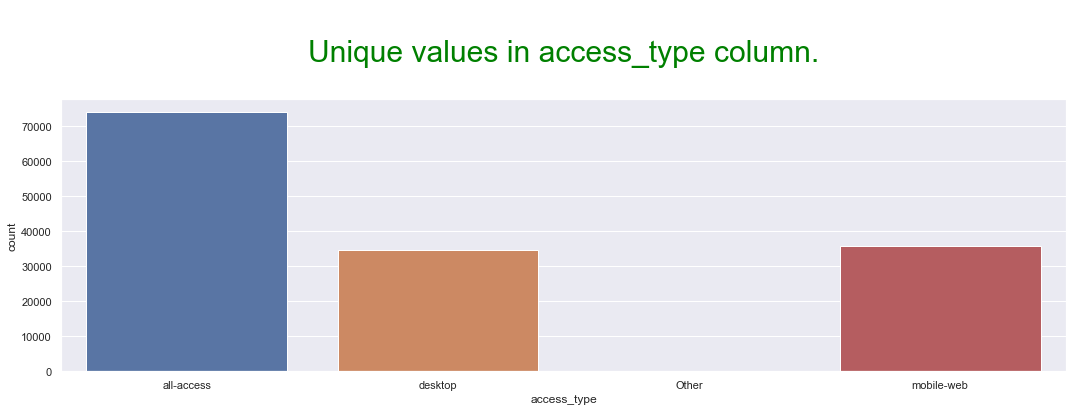

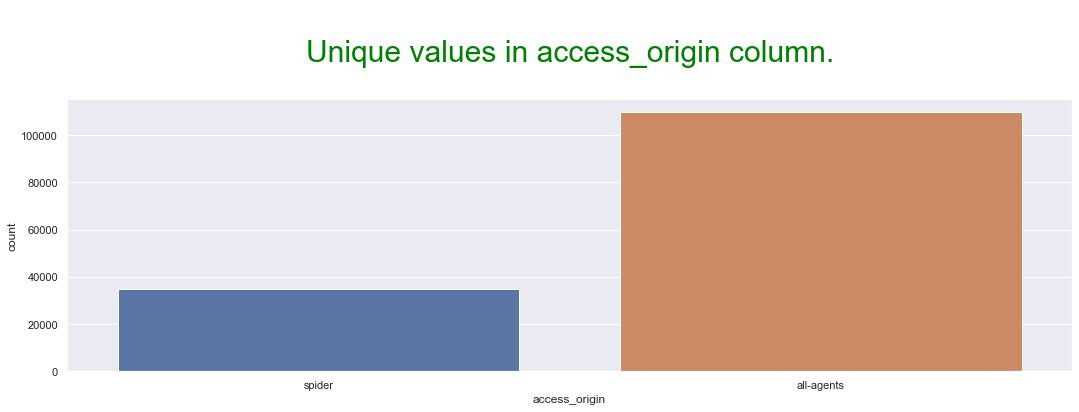

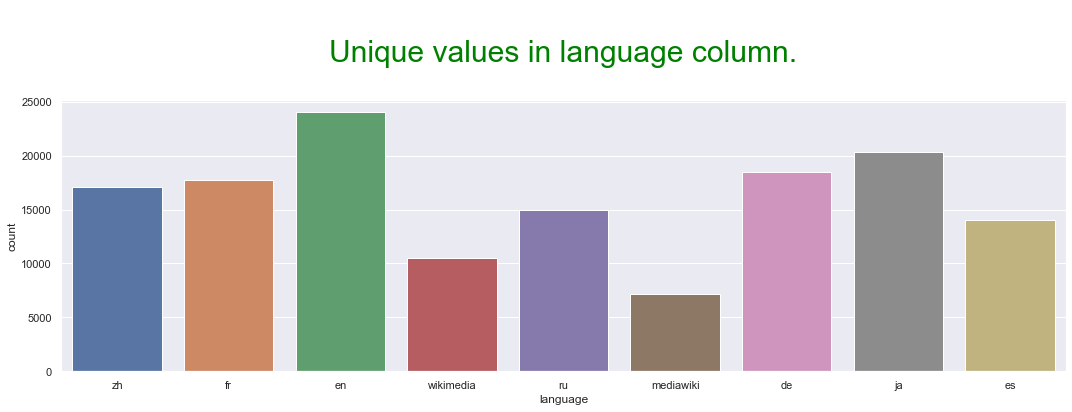

In [95]:
for column in ['access_type', 'access_origin', 'language']:
    fig, axes = plt.subplots(figsize=(18,5))
    sns.countplot(data=df, x=column)
    plt.title(f"\nUnique values in {column} column.\n", fontsize=30, color="green")
    plt.show()

***
***
## **6. Top 20 most popular pages.**

In [96]:
pd.Series(df.loc[df[df.columns[1:-4]].sum(axis = 1).sort_values(ascending=False).index].title.unique()[:20])

0                       Main_Page
1            Wikipedia:Hauptseite
2                  Special:Search
3              Заглавная_страница
4     Wikipédia:Accueil_principal
5               Wikipedia:Portada
6                   Spezial:Suche
7                          メインページ
8                 Especial:Buscar
9                    Special:Book
10                   Wikipedia:首页
11                Служебная:Поиск
12              Spécial:Recherche
13                        404.php
14                   Donald_Trump
15                 Sp?cial:Search
16                       XHamster
17                          特別:検索
18          Special:RecentChanges
19                   Web_scraping
dtype: object

***
***
## **7. Top 20 most popular English pages.**

In [97]:
english = df[df.language=='en'].reset_index(drop=True).copy()
pd.Series(english.loc[english[english.columns[1:-4]].sum(axis = 1).sort_values(ascending=False).index].title.unique()[:20])

0                                Main_Page
1                           Special:Search
2                             Special:Book
3                                  404.php
4                             Donald_Trump
5                                 XHamster
6                    Special:RecentChanges
7                             Web_scraping
8     User:GoogleAnalitycsRoman/google-api
9                              Proyecto_40
10                       Special:Watchlist
11                   Special:CreateAccount
12                                   AMGTV
13                          Deaths_in_2016
14            Star_Wars:_The_Force_Awakens
15             Special:RecentChangesLinked
16                    Special:CiteThisPage
17                      Special:MobileMenu
18                             Dulce_María
19                           Pablo_Escobar
dtype: object

***
***
## **8. Data Preprocessing - Transformation to Time Series.**

In [98]:
df_new = df[df.columns[1:-3]].groupby(['language']).sum().T.copy()

In [99]:
df_new.index = pd.to_datetime(df_new.index)

In [63]:
df_new.head()

language       0          de           en          es         fr          ja  \
2015-07-01   6.0  13260519.0  125182716.0  15278553.0  8458638.0  11863200.0   
2015-07-02   5.0  13079896.0  125008586.0  14601013.0  8512952.0  13620792.0   
2015-07-03   3.0  12554042.0  118690083.0  13427632.0  8186030.0  12305383.0   
2015-07-04  14.0  11520379.0  123522828.0  12606538.0  8749842.0  15456239.0   
2015-07-05  14.0  13392347.0  127550425.0  13710356.0  8590493.0  14827204.0   

language    mediawiki         ru  wikimedia         zh  
2015-07-01   349713.0  9463854.0  1140821.0  4144988.0  
2015-07-02   383680.0  9627643.0  1178130.0  4151189.0  
2015-07-03   325714.0  8923463.0  1150547.0  4123659.0  
2015-07-04   308756.0  8393214.0   951317.0  4163448.0  
2015-07-05   338485.0  8938528.0  1058036.0  4441286.0

In [64]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 550 entries, 2015-07-01 to 2016-12-31
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   0          550 non-null    float64
 1   de         550 non-null    float64
 2   en         550 non-null    float64
 3   es         550 non-null    float64
 4   fr         550 non-null    float64
 5   ja         550 non-null    float64
 6   mediawiki  550 non-null    float64
 7   ru         550 non-null    float64
 8   wikimedia  550 non-null    float64
 9   zh         550 non-null    float64
dtypes: float64(10)
memory usage: 47.3 KB


***
***
## **9. Distribution of Data.**

In [65]:
df_new.describe()

language            0            de            en            es            fr  \
count      550.000000  5.500000e+02  5.500000e+02  5.500000e+02  5.500000e+02   
mean        21.165455  1.611275e+07  1.571398e+08  1.725491e+07  1.159604e+07   
std         72.922220  1.992877e+06  3.462934e+07  3.294102e+06  1.857144e+06   
min          0.000000  1.144586e+07  1.133433e+08  8.960082e+06  6.915625e+06   
25%          6.000000  1.476034e+07  1.349346e+08  1.475376e+07  1.071250e+07   
50%         13.000000  1.587866e+07  1.488211e+08  1.710096e+07  1.152504e+07   
75%         18.000000  1.735169e+07  1.679985e+08  2.019713e+07  1.246444e+07   
max       1373.000000  2.376035e+07  3.001195e+08  2.987194e+07  1.977308e+07   

language            ja     mediawiki            ru     wikimedia            zh  
count     5.500000e+02  5.500000e+02  5.500000e+02  5.500000e+02  5.500000e+02  
mean      1.558416e+07  4.169180e+05  1.454248e+07  1.908118e+06  5.767246e+06  
std       2.475992e+06  2.341937e+05  5.739684e+06  5.817207e+05  1.006086e+06  
min       8.862033e+06  2.076710e+05  7.427083e+06  9.108510e+05  3.071108e+06  
25%       1.379938e+07  3.201498e+05  1.223083e+07  1.473120e+06  4.897222e+06  
50%       1.553903e+07  3.707965e+05  1.358558e+07  1.813873e+06  5.927902e+06  
75%       1.717117e+07  4.391642e+05  1.480554e+07  2.179001e+06  6.417991e+06  
max       2.942200e+07  2.422944e+06  4.453718e+07  5.993197e+06  1.092263e+07

***
***
## **10. Univariate analysis - Continuous Data.**

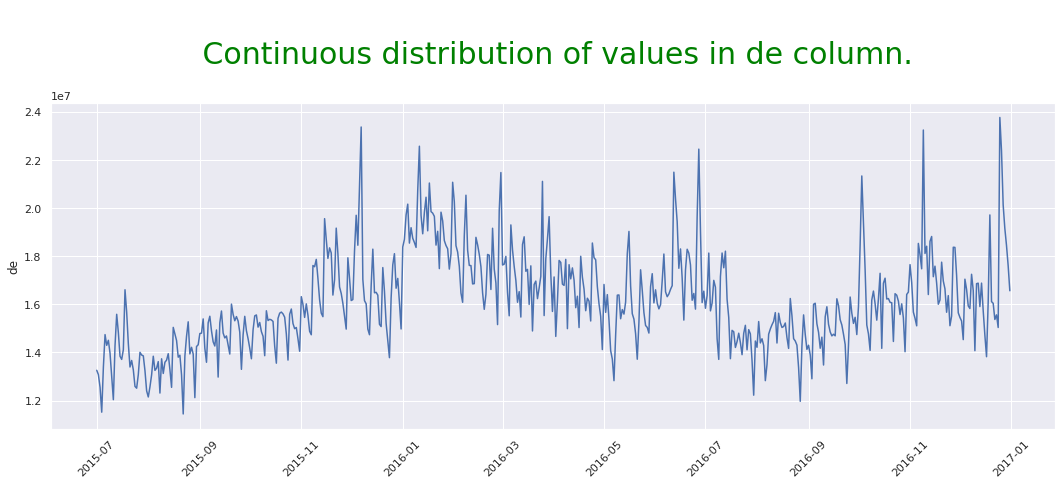

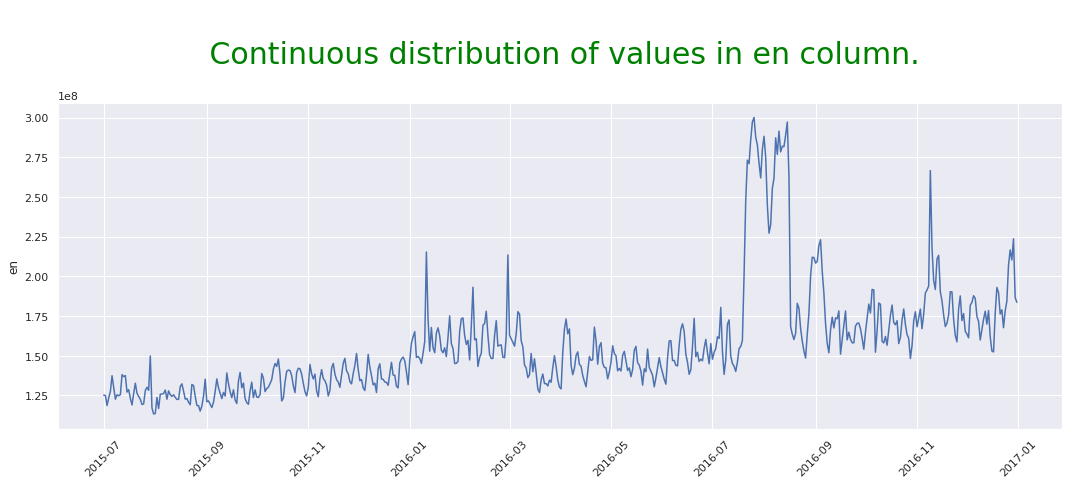

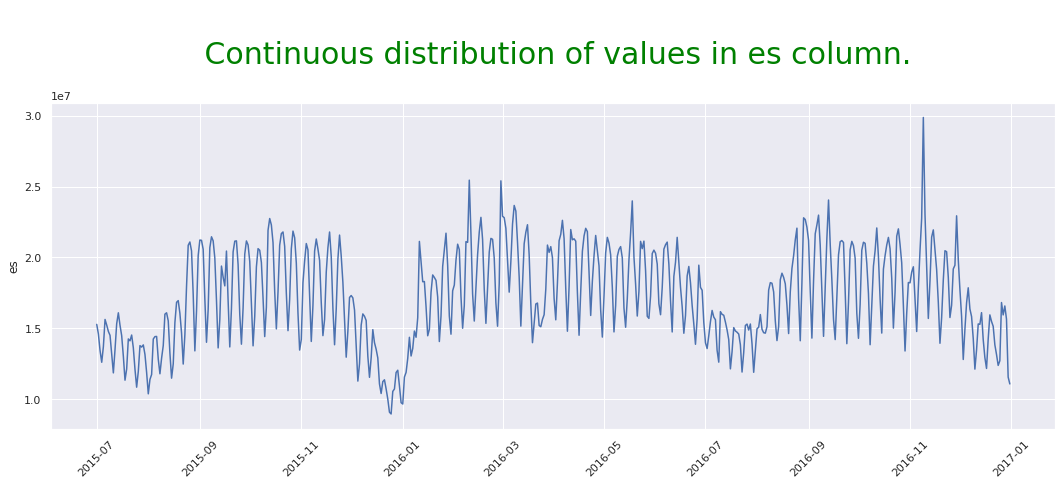

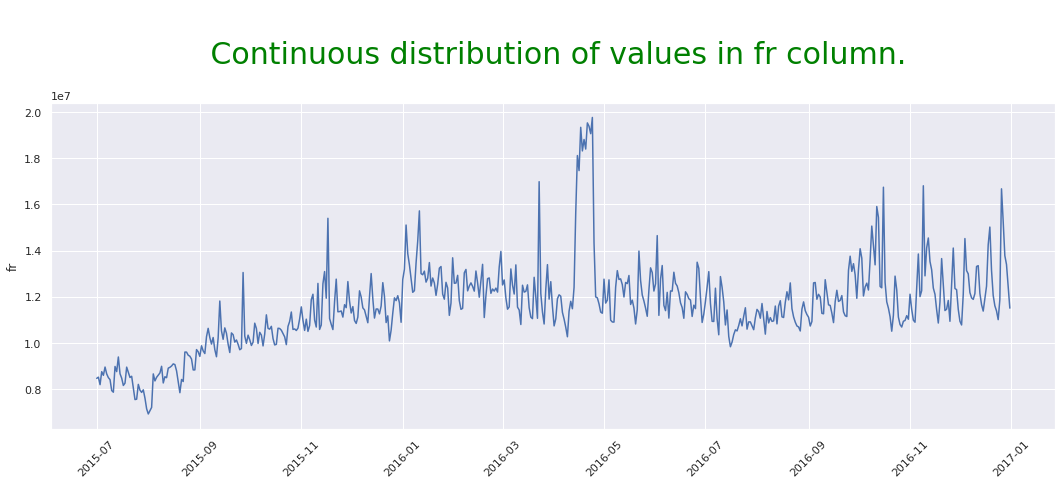

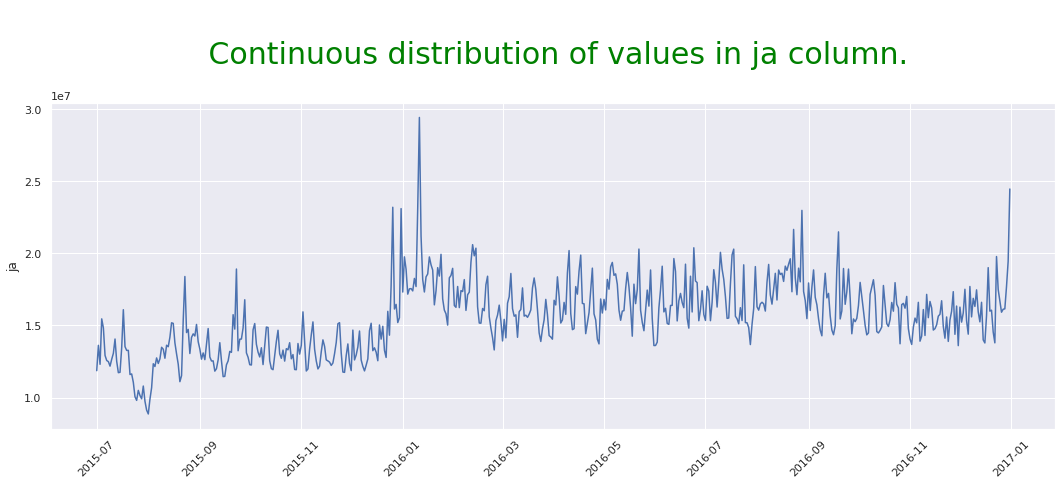

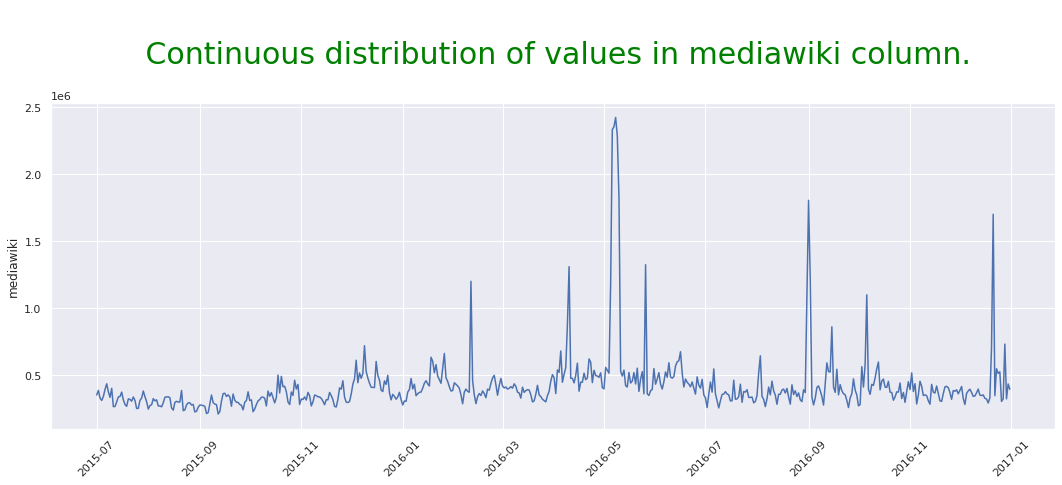

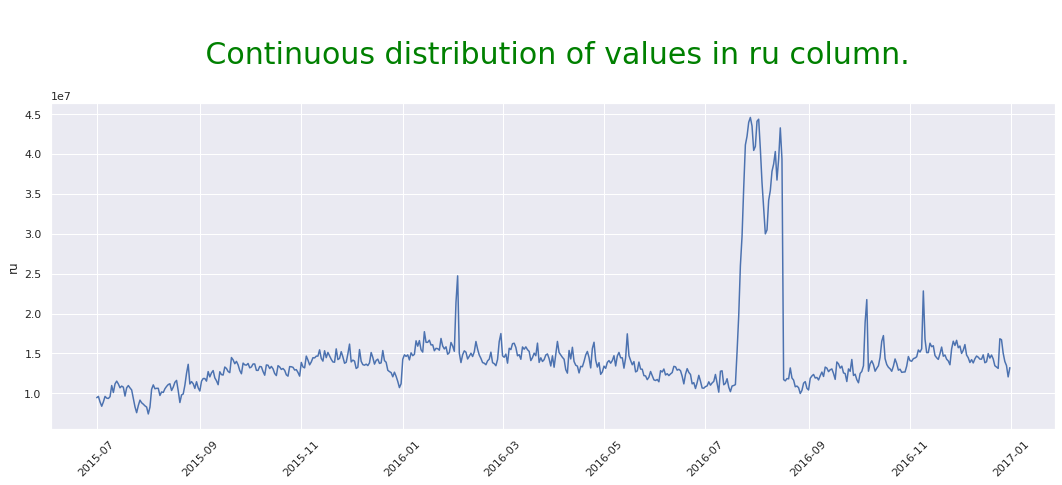

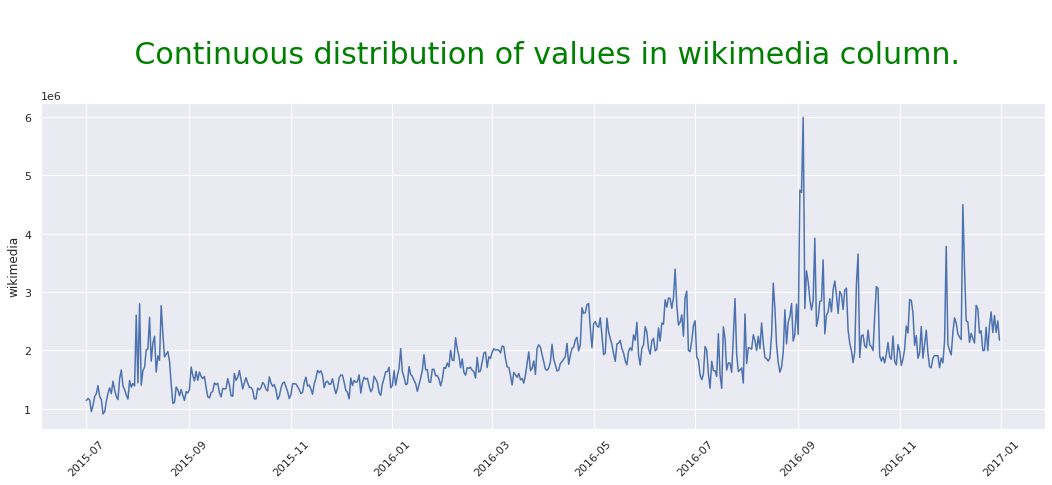

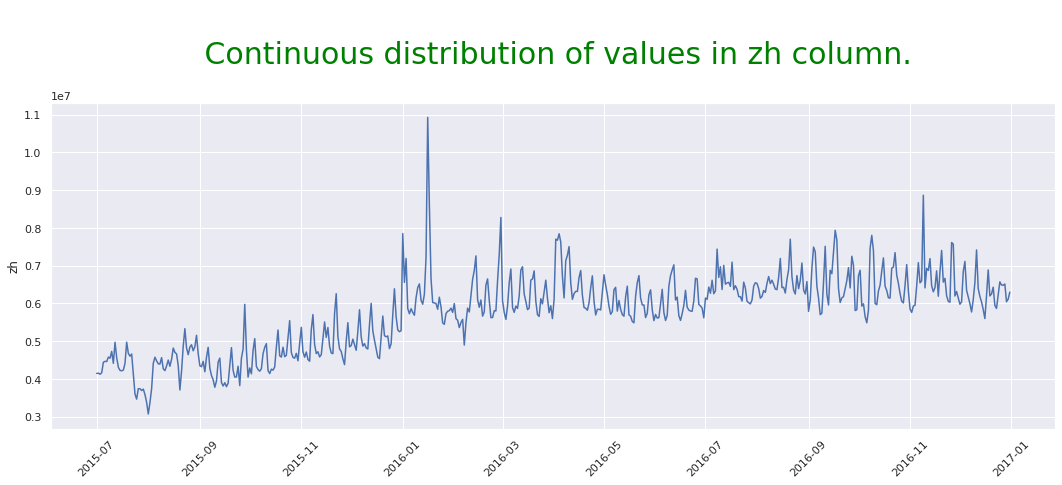

In [70]:
for column in df_new.columns[1:]:
    fig, ax = plt.subplots(figsize=(18, 6))
    sns_plot = sns.lineplot(x=df_new.index, y=df_new[column])
    plt.xticks(rotation=45)
    plt.title(f"\n Continuous distribution of values in {column} column.\n", fontsize=30, color="green")
    plt.show()

***
***
## **10. Analyze ADF (Dicky-Fuller Test) Statistic to check Stationarity.**

In [71]:
for column in df_new.columns[1:]:
    print(f"\nFor column {column}\n")
    result = adfuller(df_new[column])
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))


For column de

ADF Statistic: -2.402707
p-value: 0.140974
Critical Values:
	1%: -3.443
	5%: -2.867
	10%: -2.570

For column en

ADF Statistic: -2.262742
p-value: 0.184266
Critical Values:
	1%: -3.443
	5%: -2.867
	10%: -2.570

For column es

ADF Statistic: -3.014209
p-value: 0.033589
Critical Values:
	1%: -3.443
	5%: -2.867
	10%: -2.570

For column fr

ADF Statistic: -2.849875
p-value: 0.051495
Critical Values:
	1%: -3.443
	5%: -2.867
	10%: -2.570

For column ja

ADF Statistic: -2.555394
p-value: 0.102571
Critical Values:
	1%: -3.442
	5%: -2.867
	10%: -2.570

For column mediawiki

ADF Statistic: -6.338871
p-value: 0.000000
Critical Values:
	1%: -3.442
	5%: -2.867
	10%: -2.570

For column ru

ADF Statistic: -3.924031
p-value: 0.001865
Critical Values:
	1%: -3.442
	5%: -2.867
	10%: -2.570

For column wikimedia

ADF Statistic: -2.840051
p-value: 0.052777
Critical Values:
	1%: -3.442
	5%: -2.867
	10%: -2.570

For column zh

ADF Statistic: -1.668433
p-value: 0.447446
Critical Values:
	1%: -

***
***
### Time series for Spanish, French, Russian, Mediawiki and wikimedia are stationary. Rest all are non stationary.

***
***
## **10. Decomposition of Series into Trend, Seasonality and Residuals.**

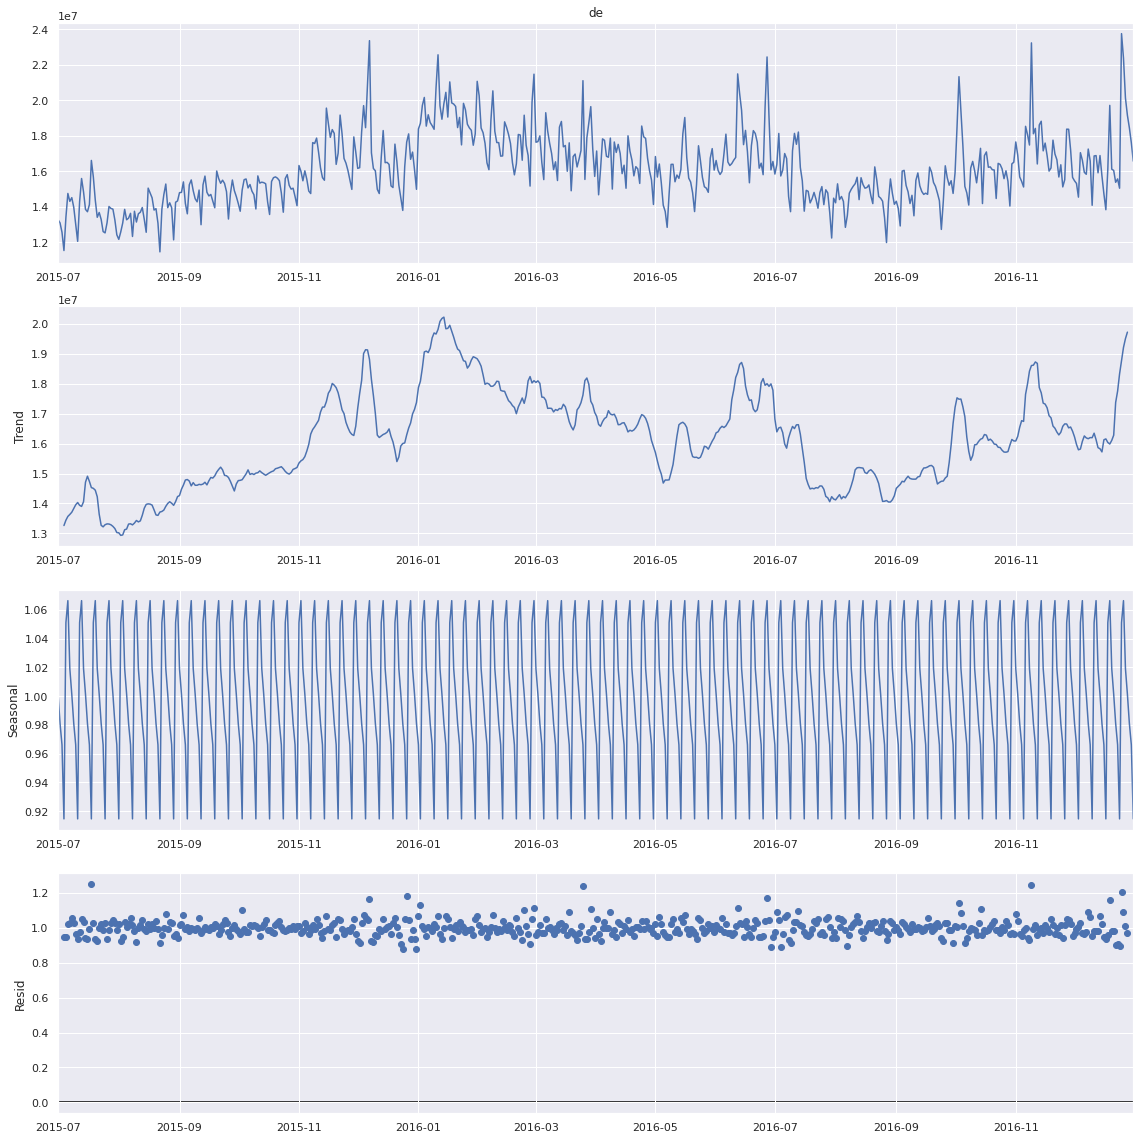

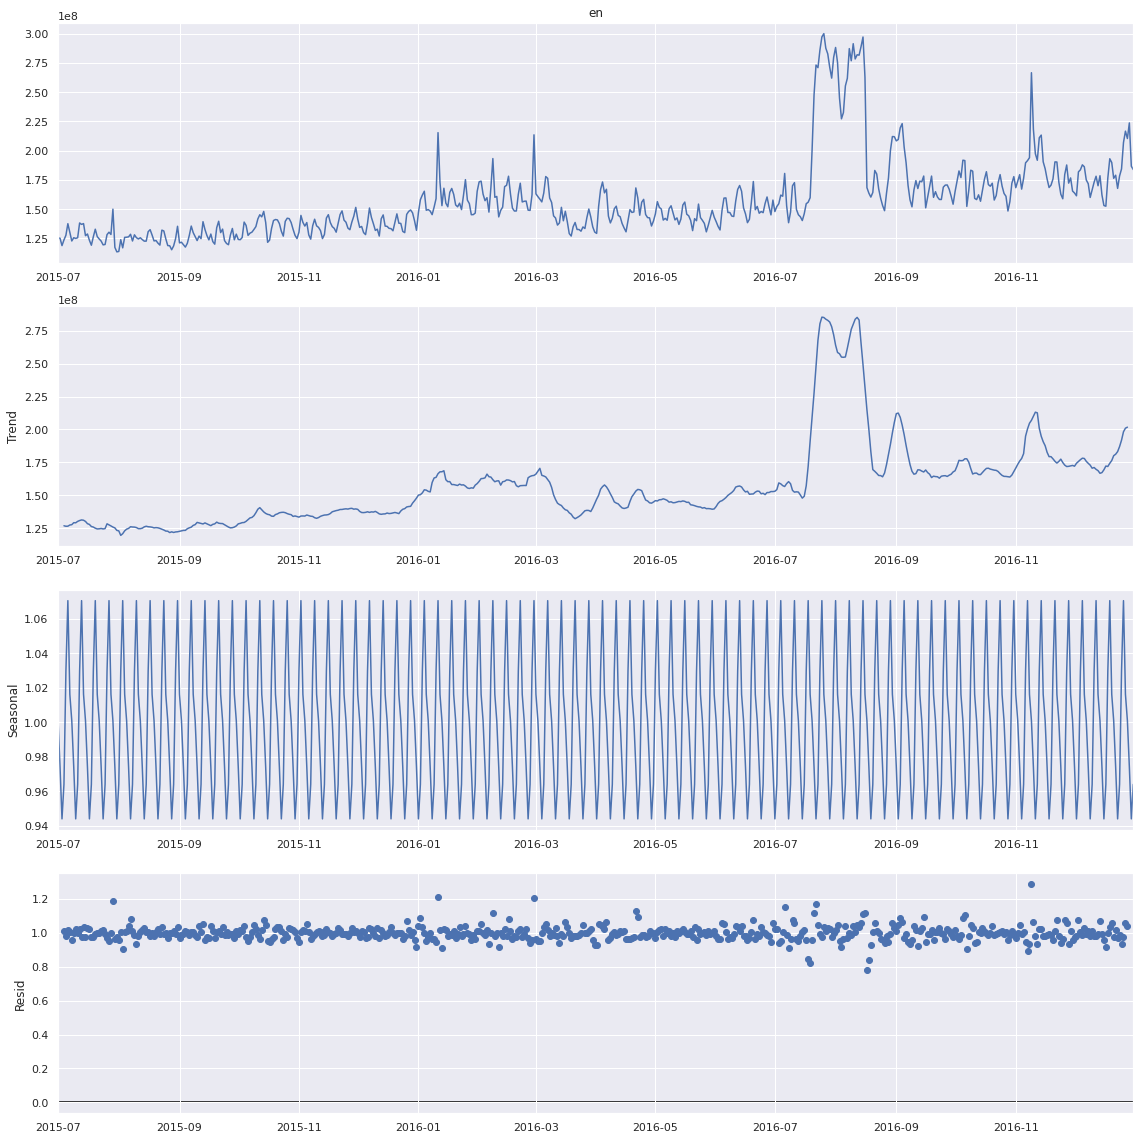

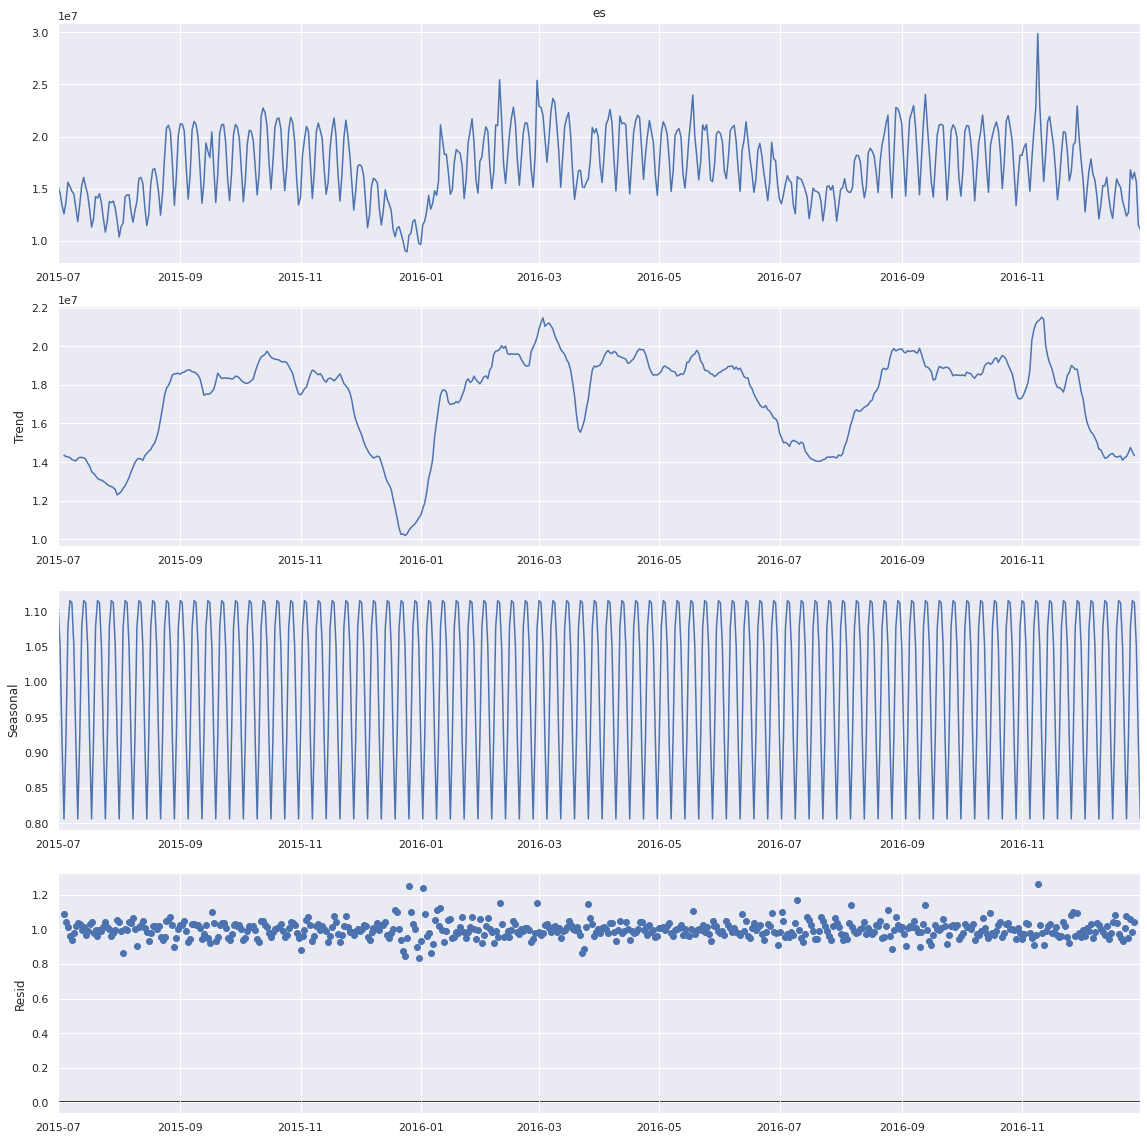

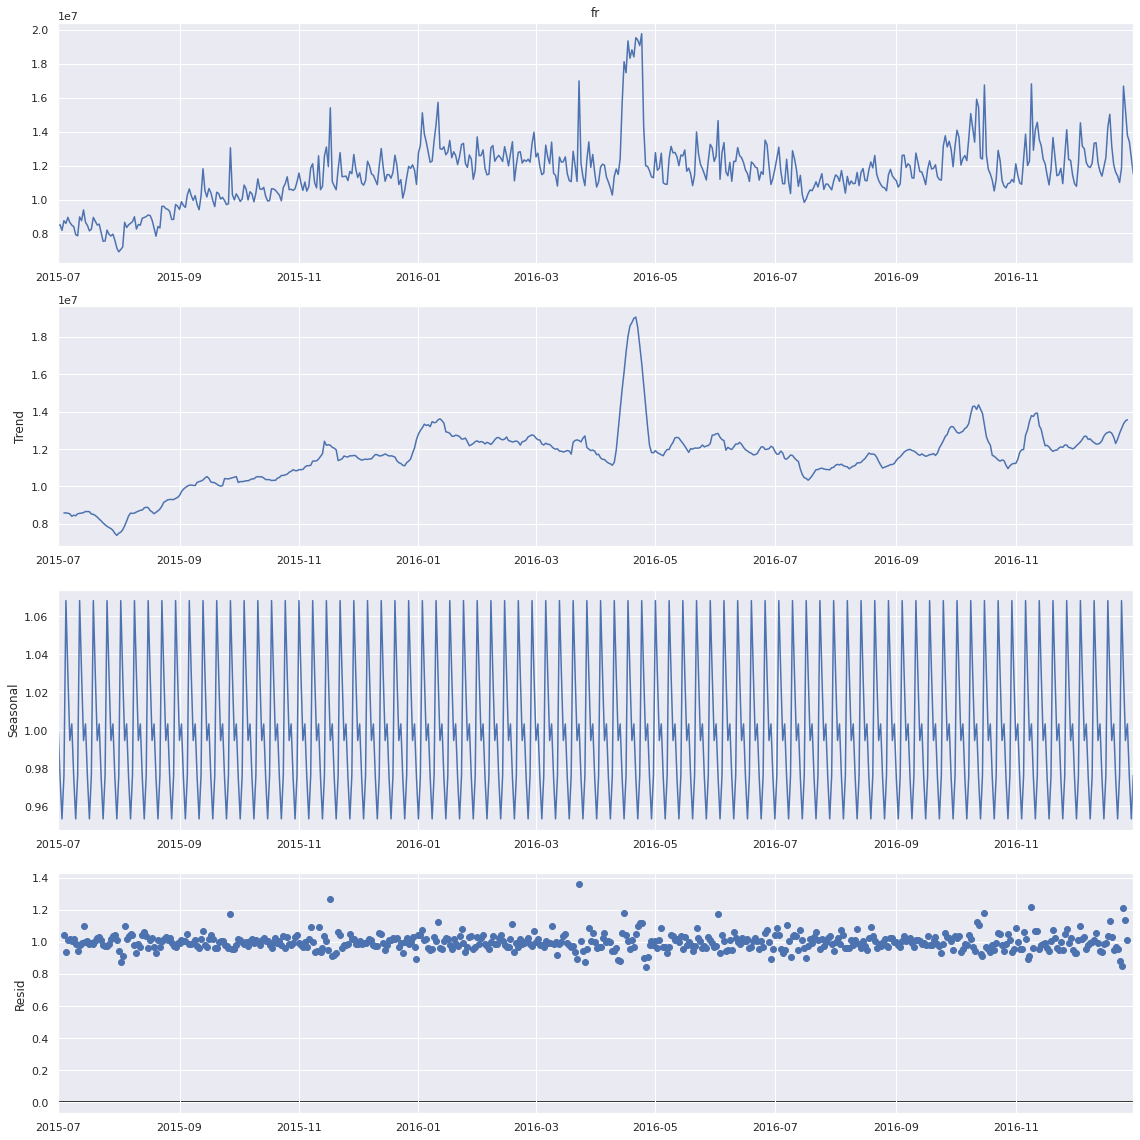

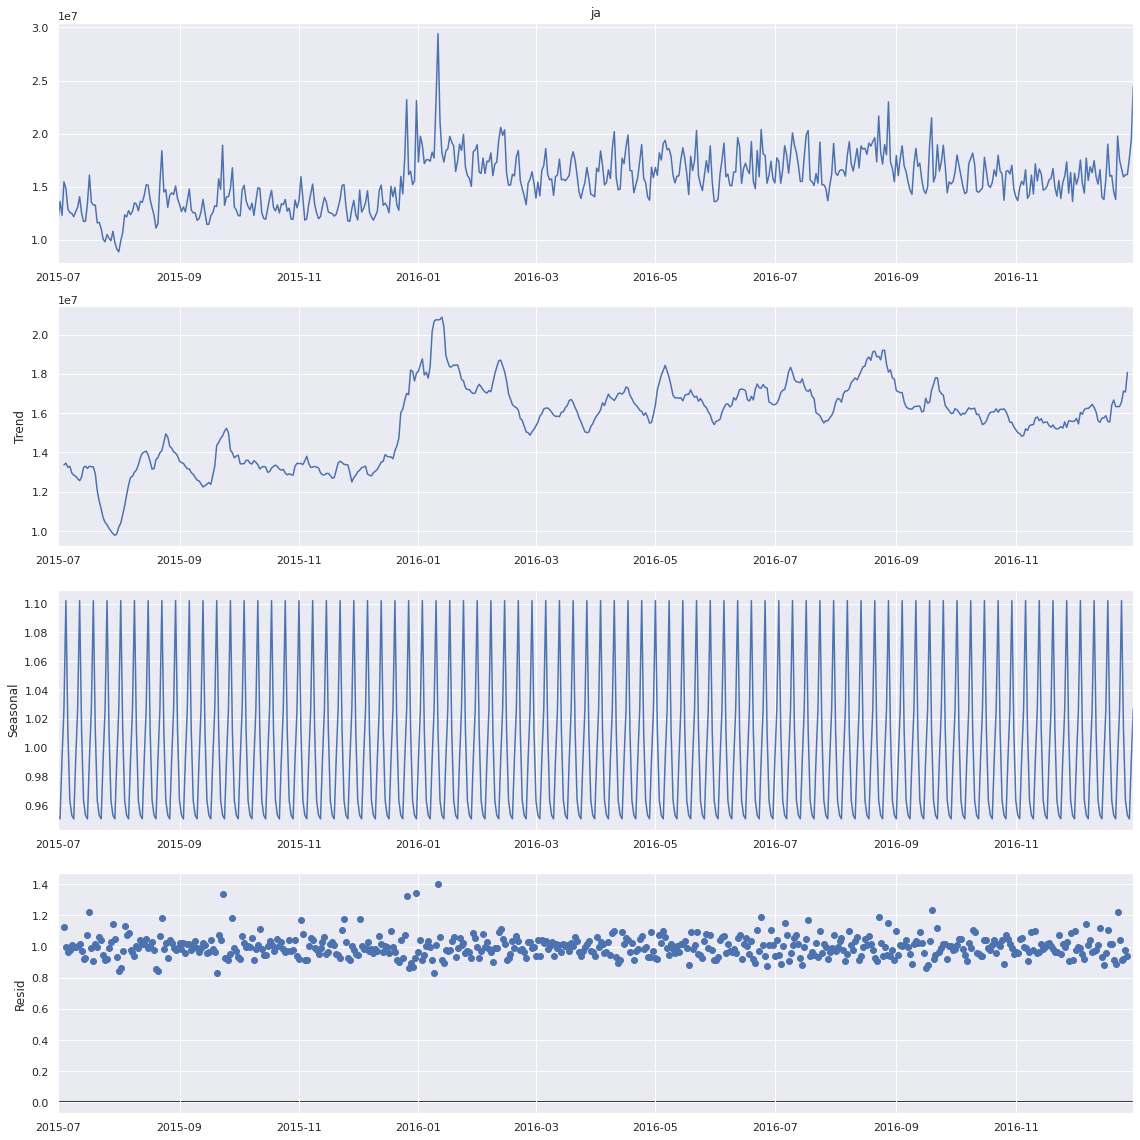

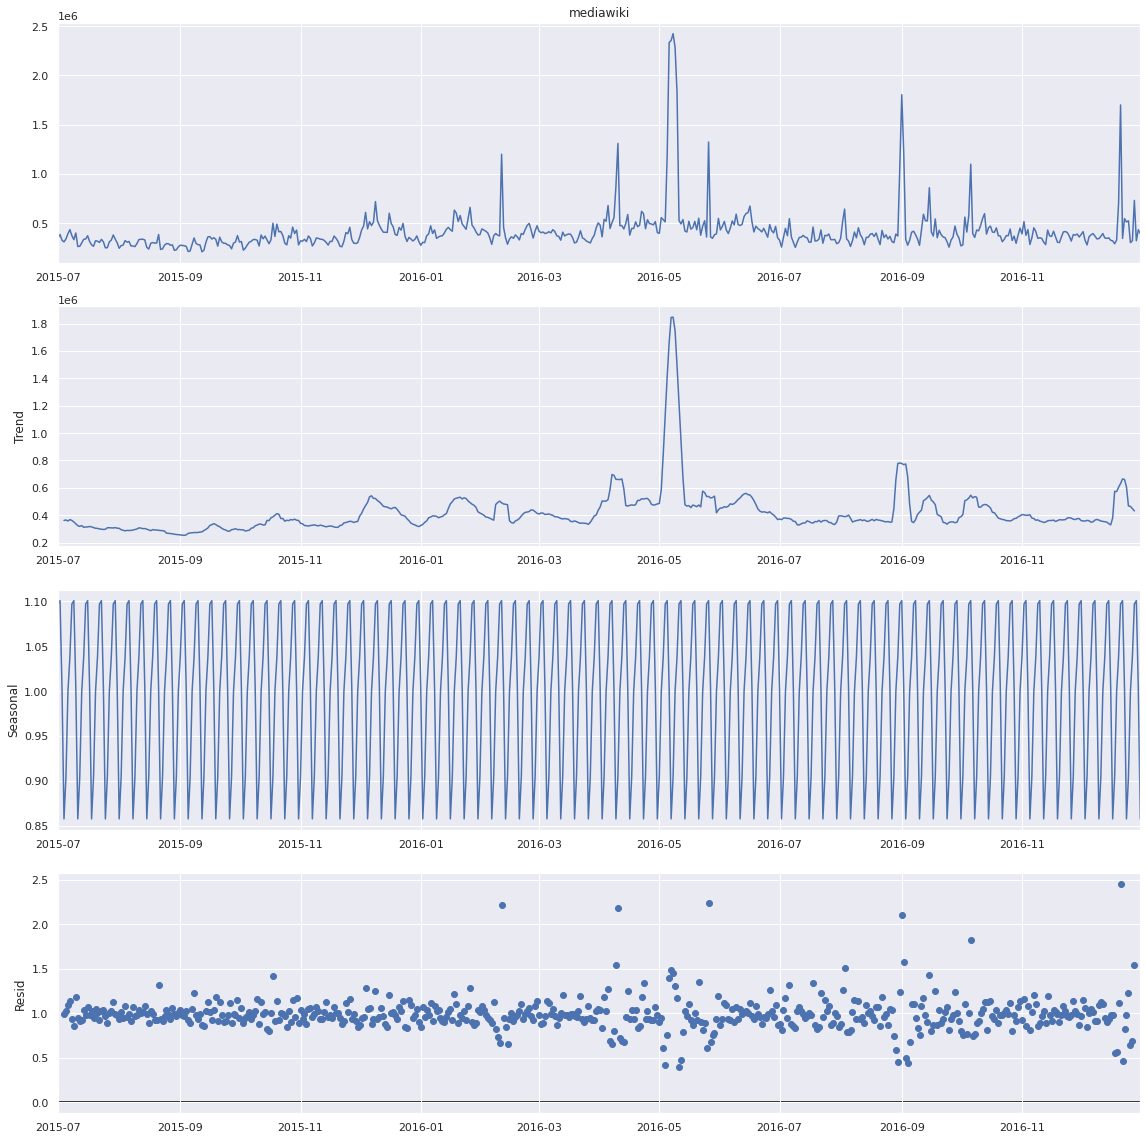

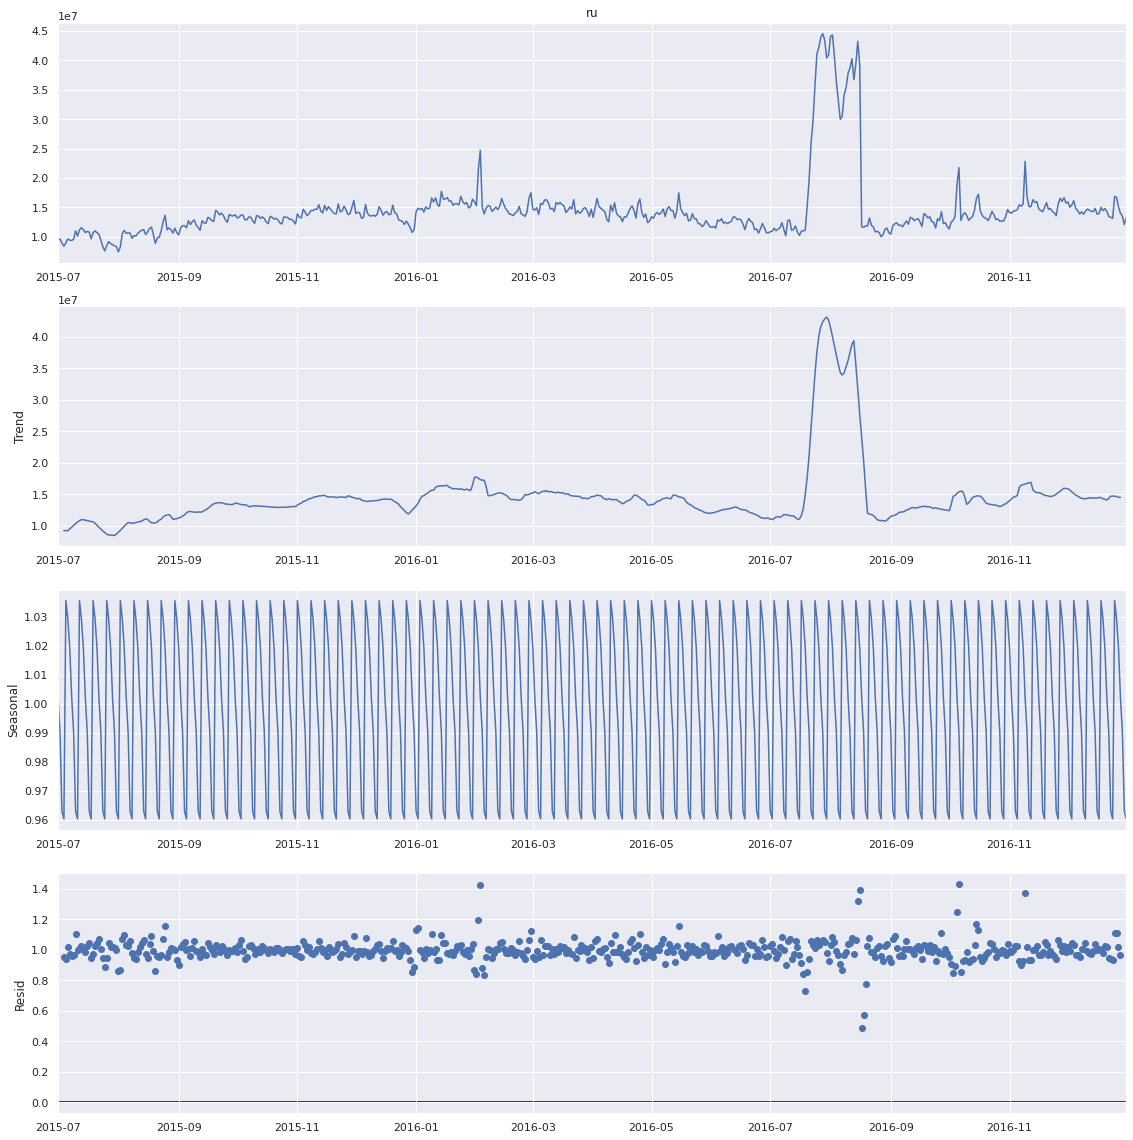

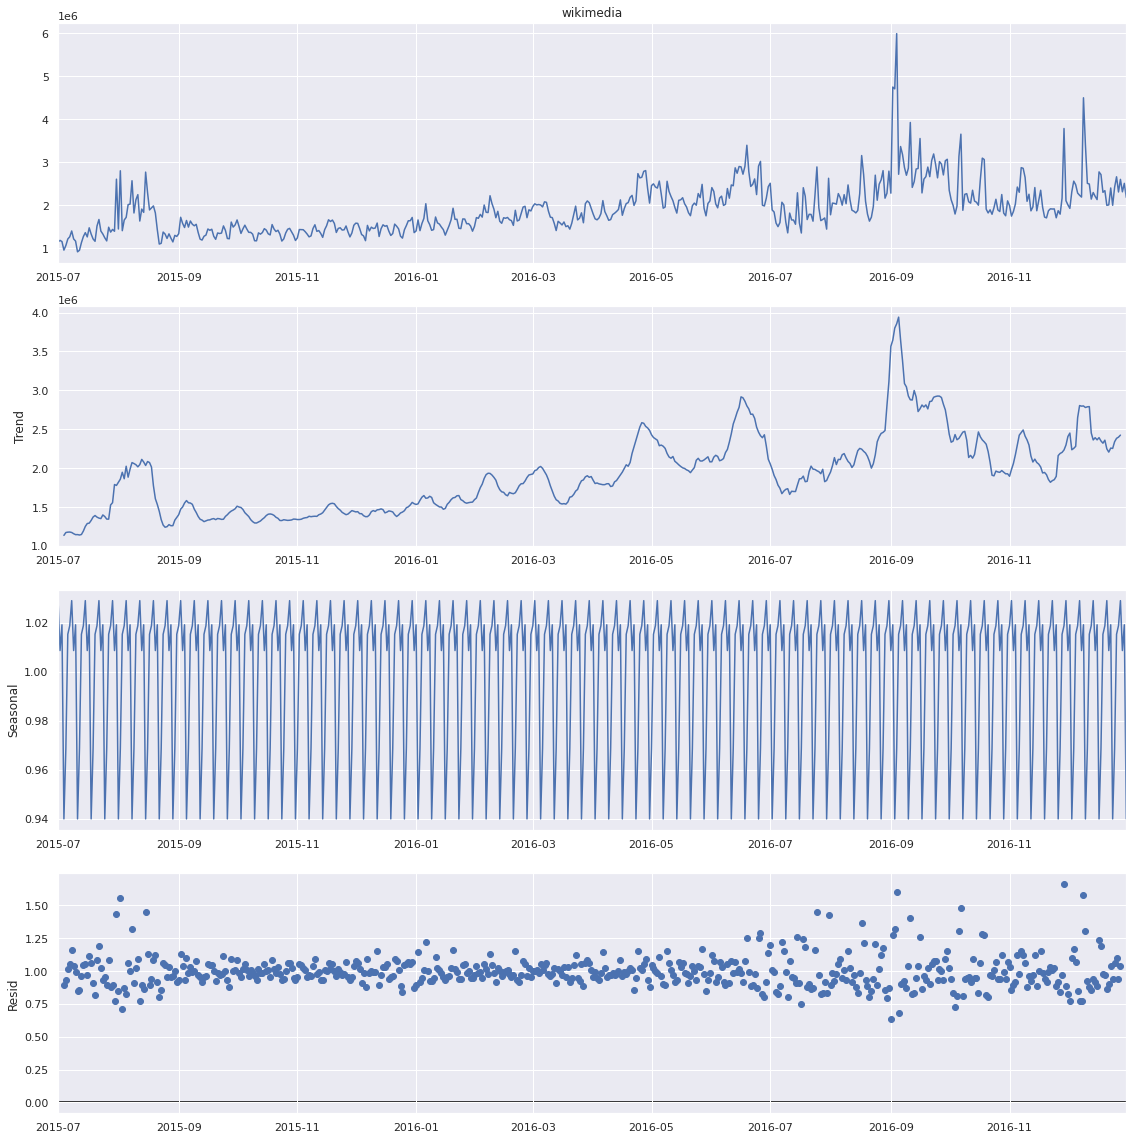

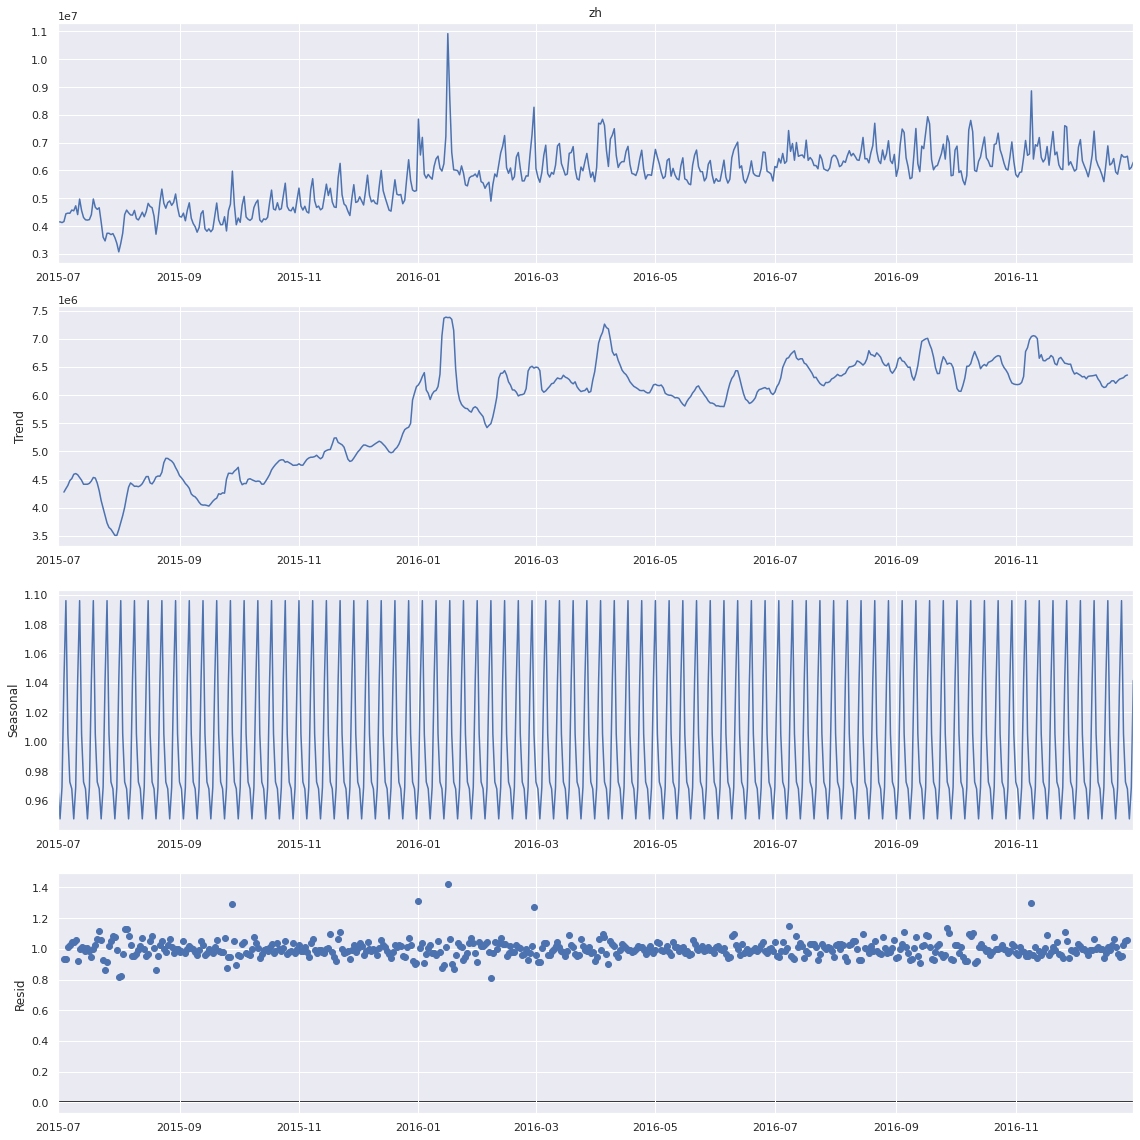

In [73]:
residuals = {}
seasonalities = {}
trends = {}
for column in df_new.columns[1:]:
    result = seasonal_decompose(df_new[column], model='multiplicative', period=7)
    residuals[column] = result.resid
    seasonalities[column] = result.seasonal
    trends[column] = result.trend
    fig = result.plot()
    fig.set_size_inches((16, 16))
    fig.tight_layout()
    plt.show()

***
***
## **11. Differencing all Time Series.**

In [74]:
df_diff = df_new.copy()

In [75]:
for column in df_diff.columns:
    df_diff[column] = df_diff[column]-df_diff[column].shift(1)

In [76]:
df_diff.dropna(inplace=True)

In [77]:
df_diff.dropna(inplace=True)

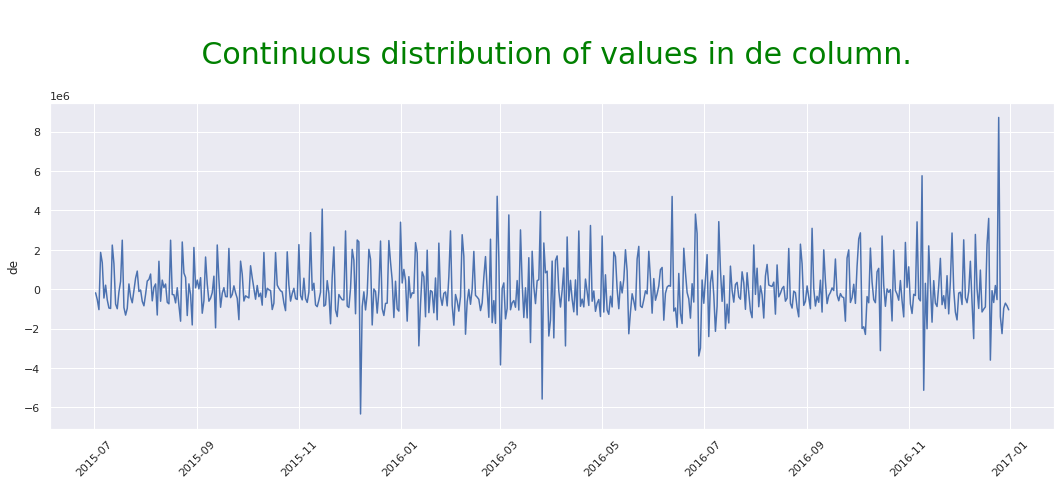

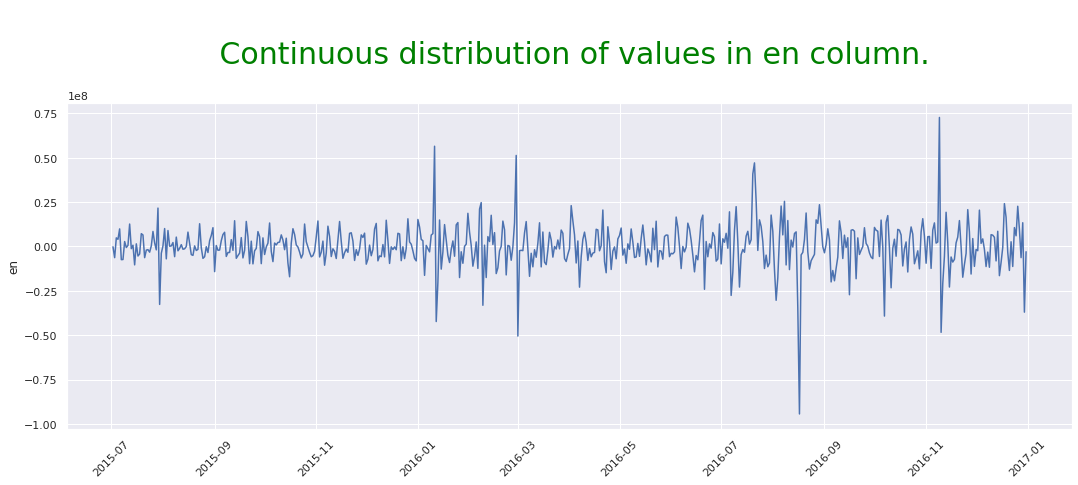

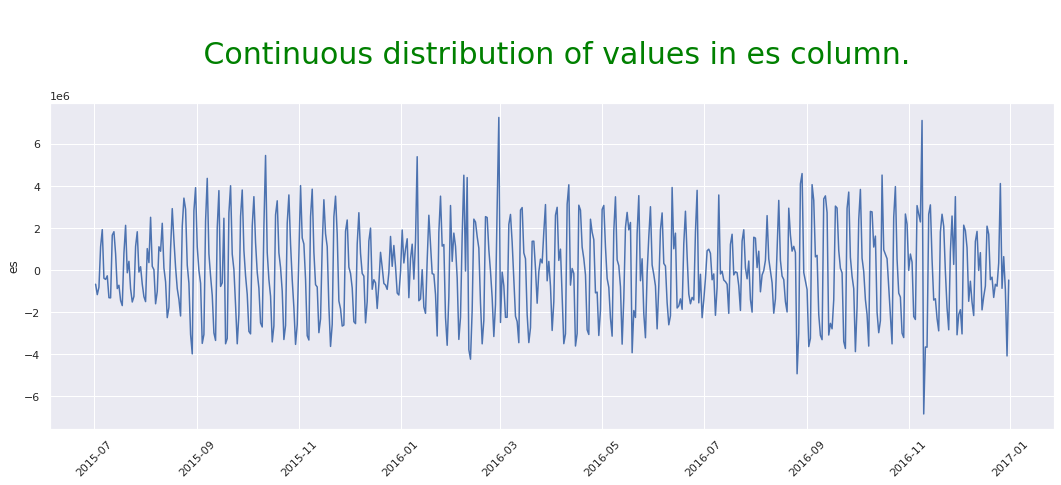

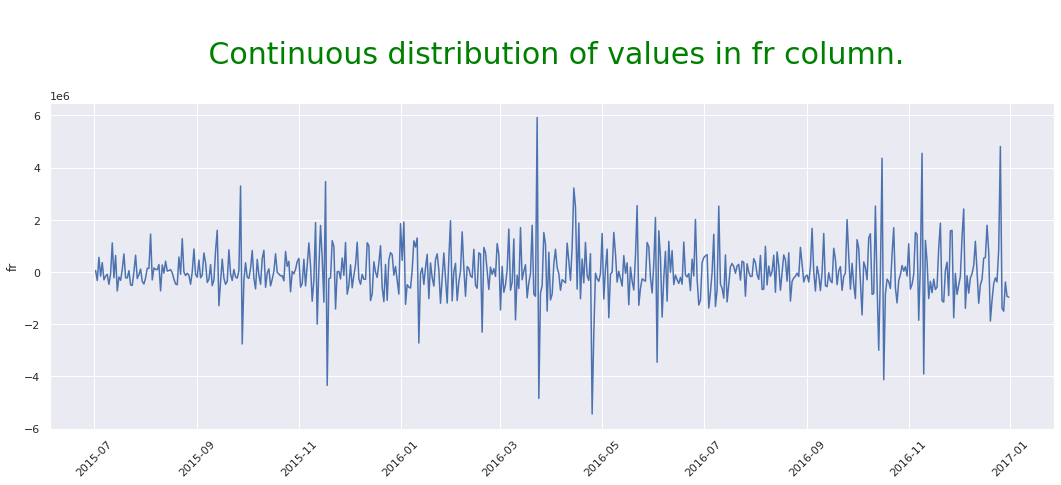

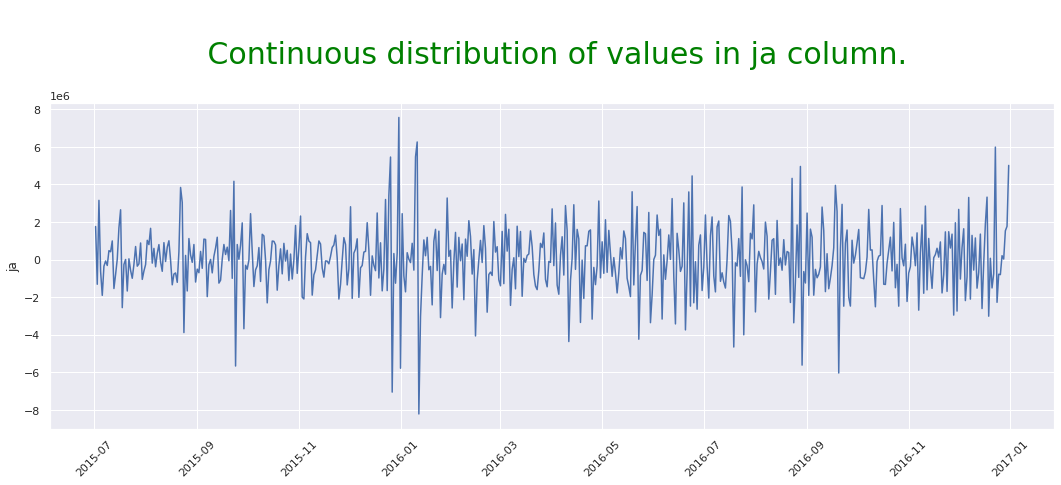

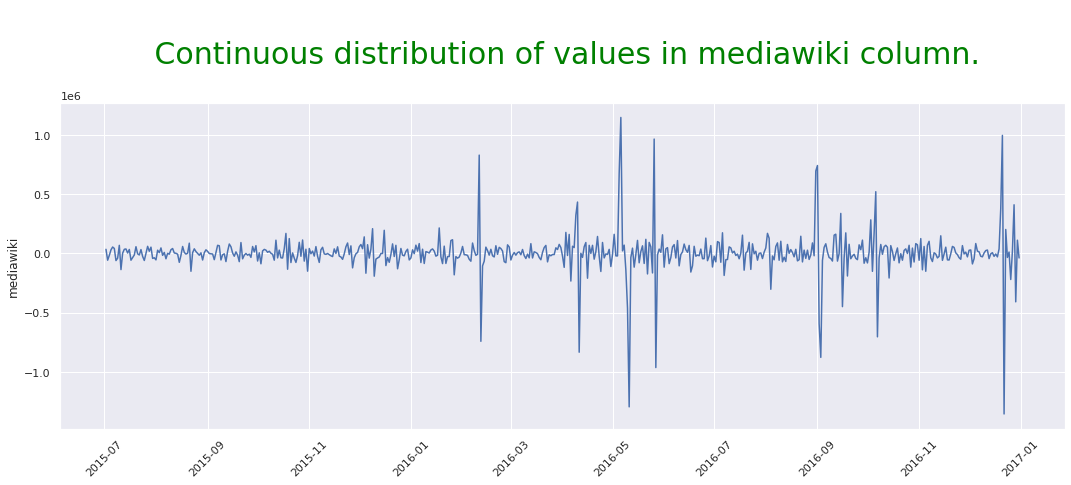

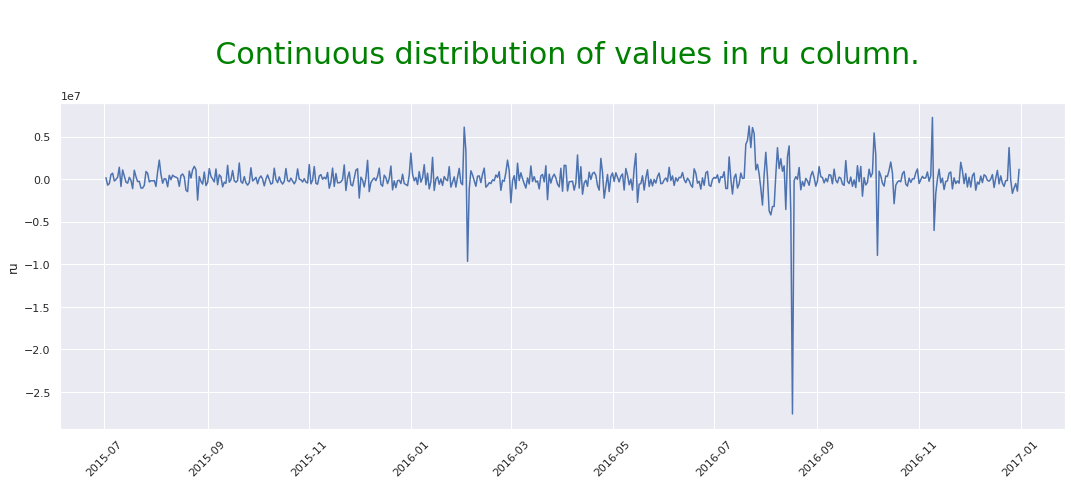

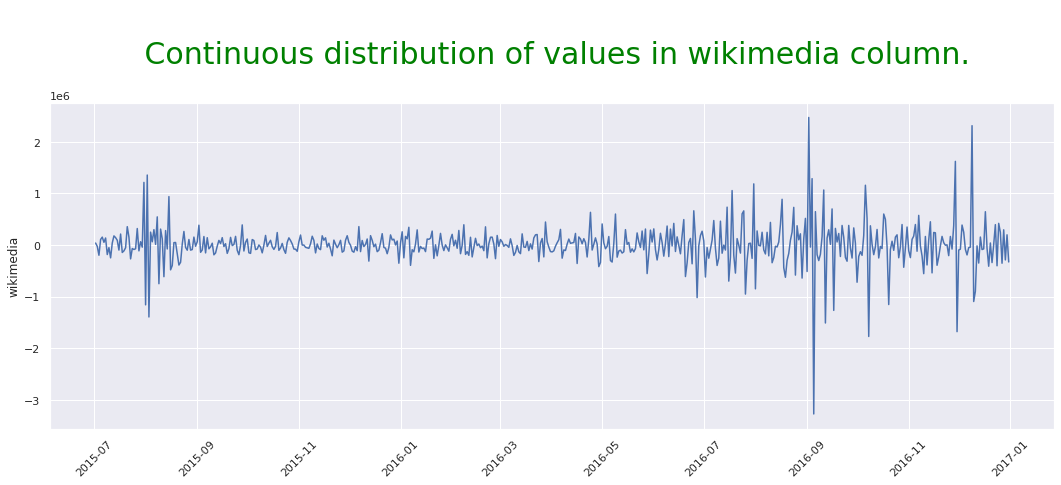

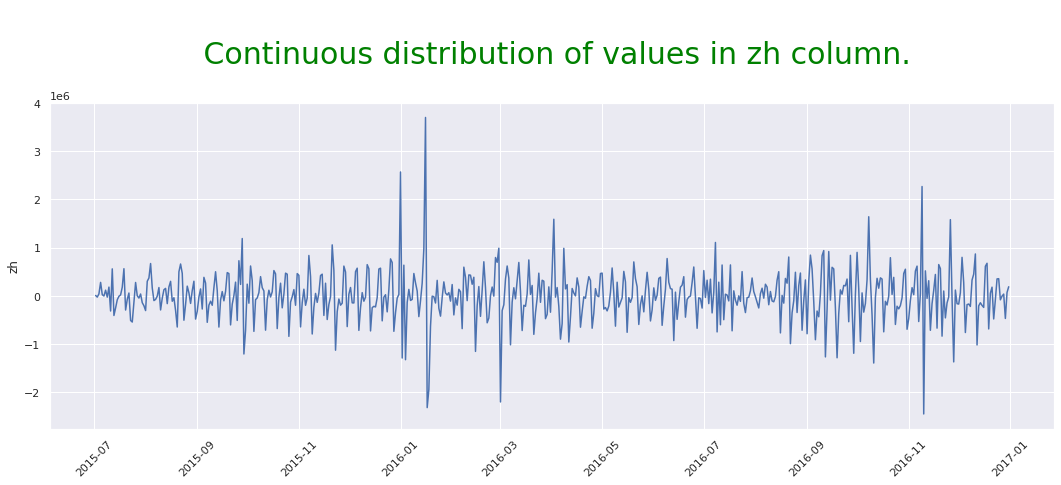

In [79]:
for column in df_diff.columns[1:]:
    fig, ax = plt.subplots(figsize=(18, 6))
    sns_plot = sns.lineplot(x=df_diff.index, y=df_diff[column])
    plt.xticks(rotation=45)
    plt.title(f"\n Continuous distribution of values in {column} column.\n", fontsize=30, color="green")
    plt.show()

***
***
## **12. Checking stationarity of differentiated all Time Series using Dicky-fuller Test.**

In [82]:
for column in df_diff.columns[1:]:
    print(f"\nFor column {column}\n")
    result = adfuller(df_diff[column])
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))


For column de

ADF Statistic: -7.206924
p-value: 0.000000
Critical Values:
	1%: -3.443
	5%: -2.867
	10%: -2.570

For column en

ADF Statistic: -8.158437
p-value: 0.000000
Critical Values:
	1%: -3.443
	5%: -2.867
	10%: -2.570

For column es

ADF Statistic: -6.020441
p-value: 0.000000
Critical Values:
	1%: -3.443
	5%: -2.867
	10%: -2.570

For column fr

ADF Statistic: -10.102724
p-value: 0.000000
Critical Values:
	1%: -3.443
	5%: -2.867
	10%: -2.570

For column ja

ADF Statistic: -11.014704
p-value: 0.000000
Critical Values:
	1%: -3.442
	5%: -2.867
	10%: -2.570

For column mediawiki

ADF Statistic: -9.645078
p-value: 0.000000
Critical Values:
	1%: -3.443
	5%: -2.867
	10%: -2.570

For column ru

ADF Statistic: -18.144426
p-value: 0.000000
Critical Values:
	1%: -3.442
	5%: -2.867
	10%: -2.570

For column wikimedia

ADF Statistic: -16.486623
p-value: 0.000000
Critical Values:
	1%: -3.442
	5%: -2.867
	10%: -2.570

For column zh

ADF Statistic: -7.722331
p-value: 0.000000
Critical Values:
	1

***
***
### All differentiated Time Series are stationary.

***
***
## **13. Autocorrelation Function on all differentiated Time Series.**

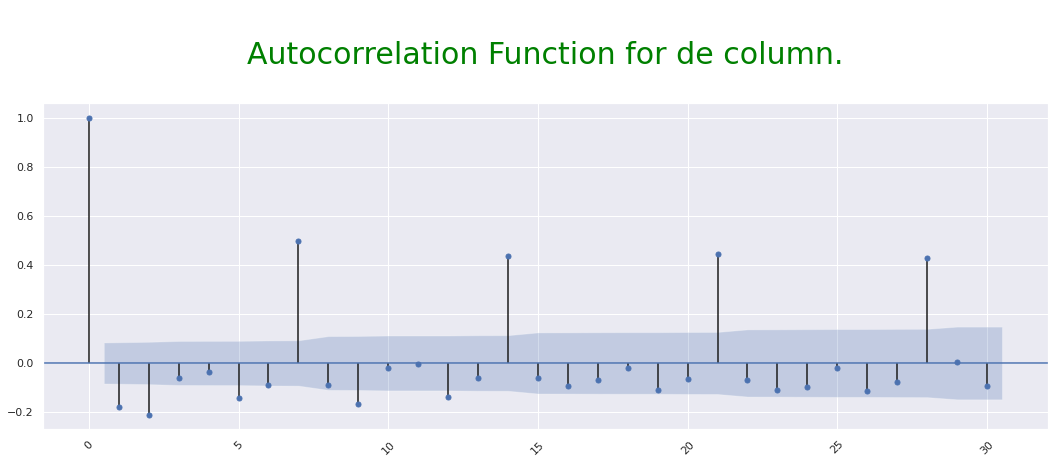

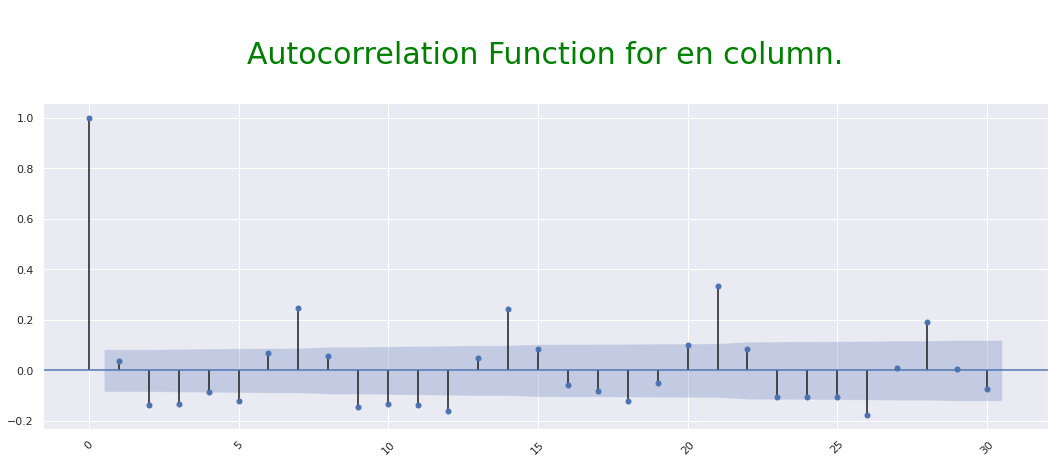

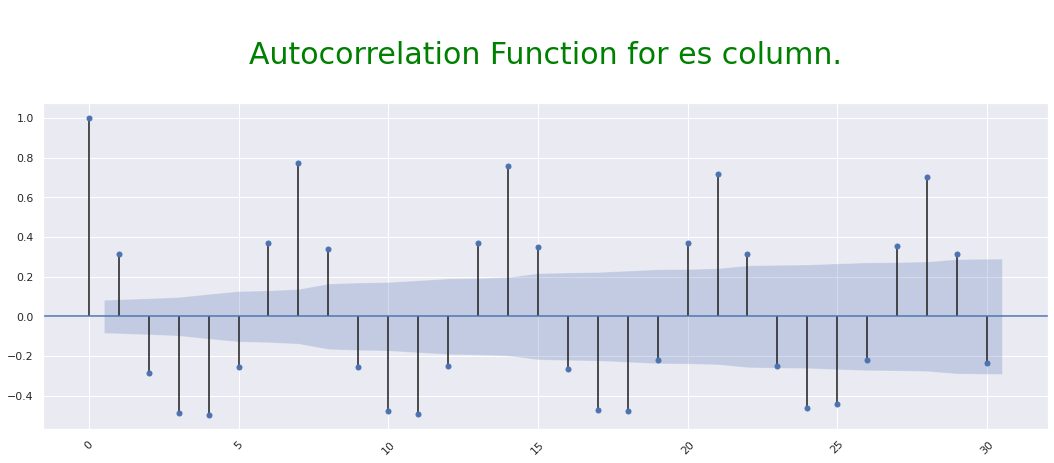

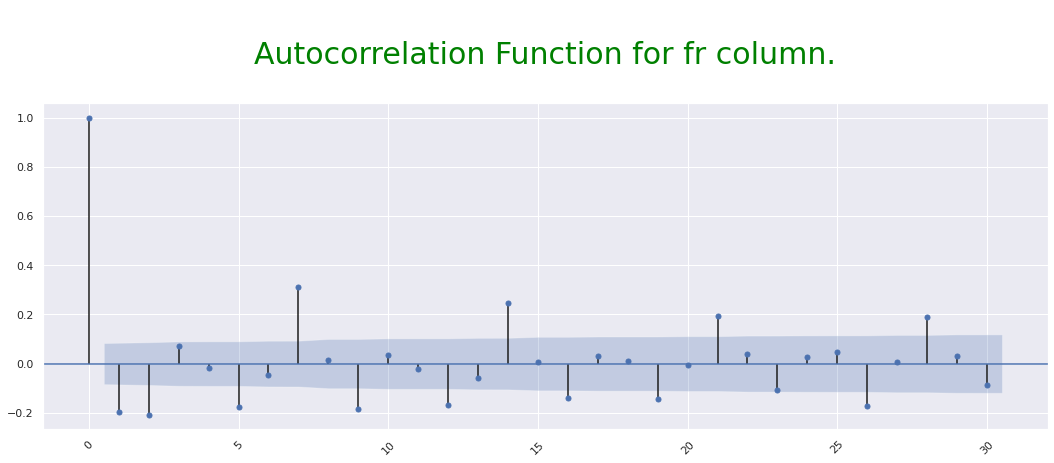

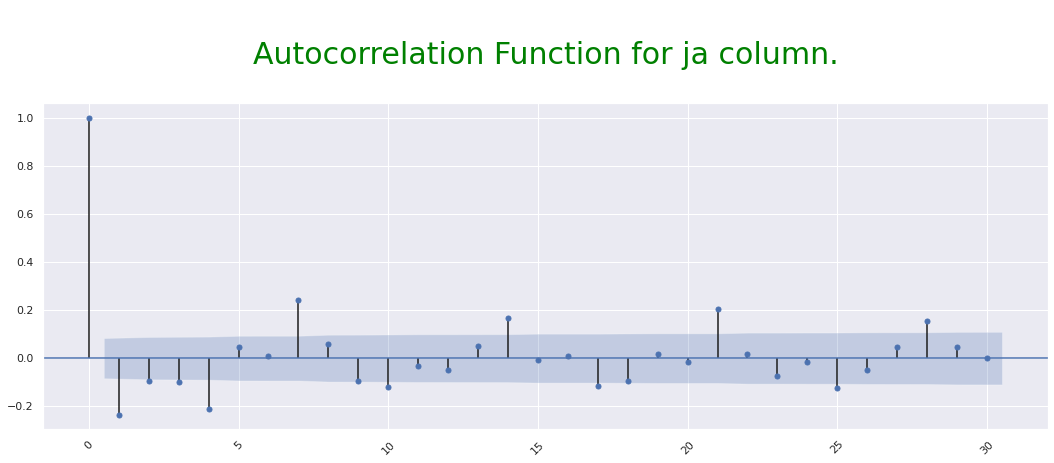

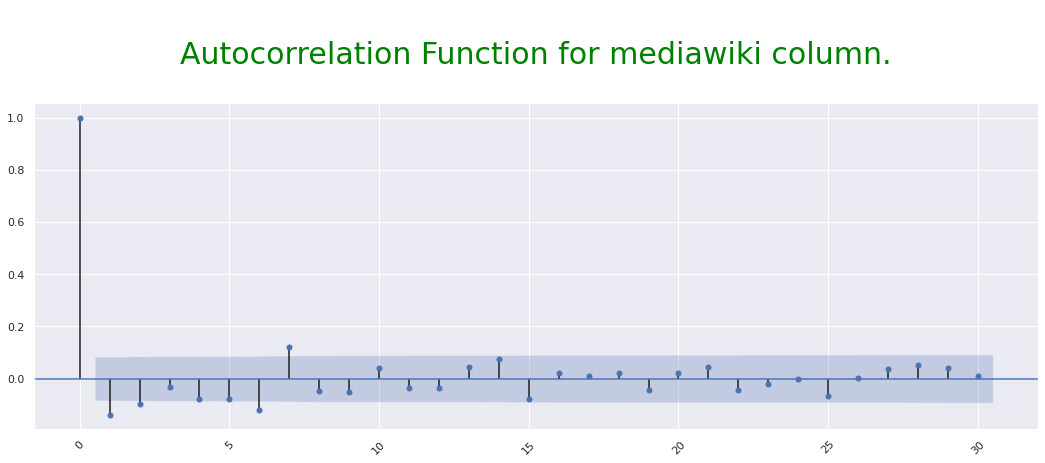

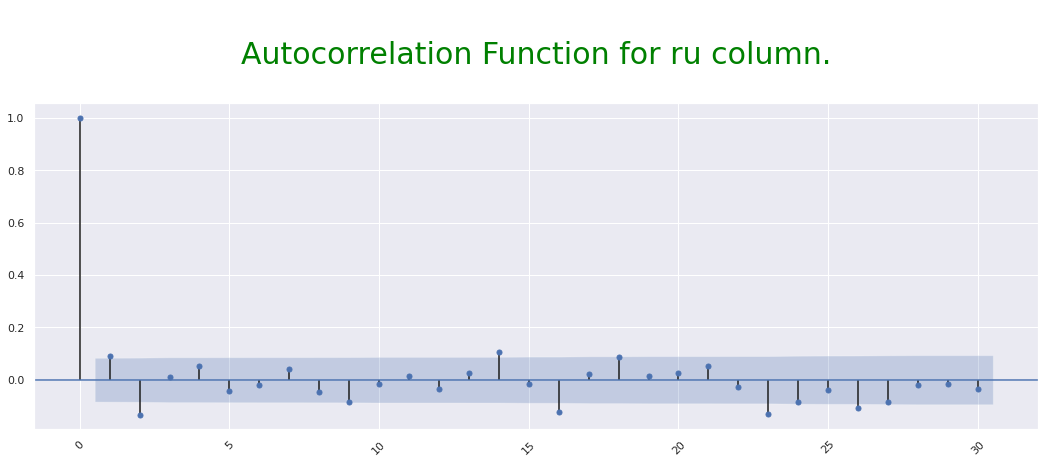

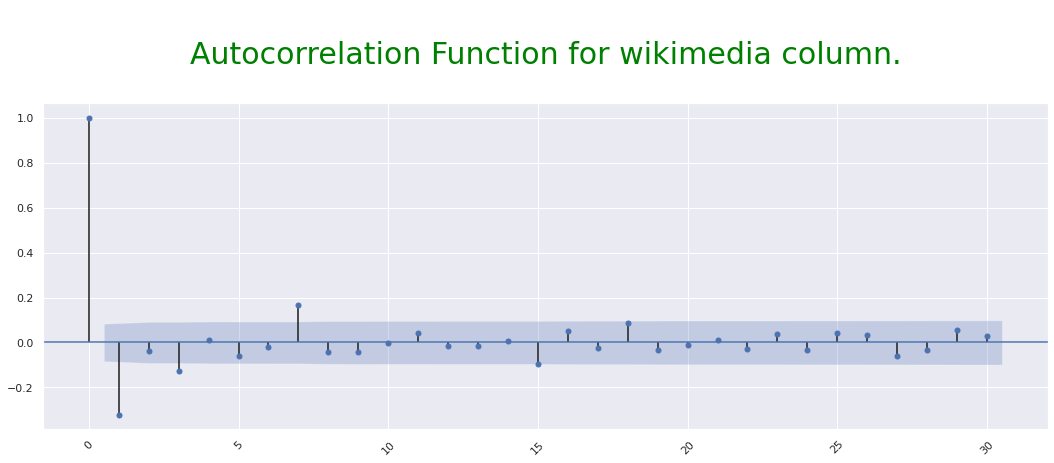

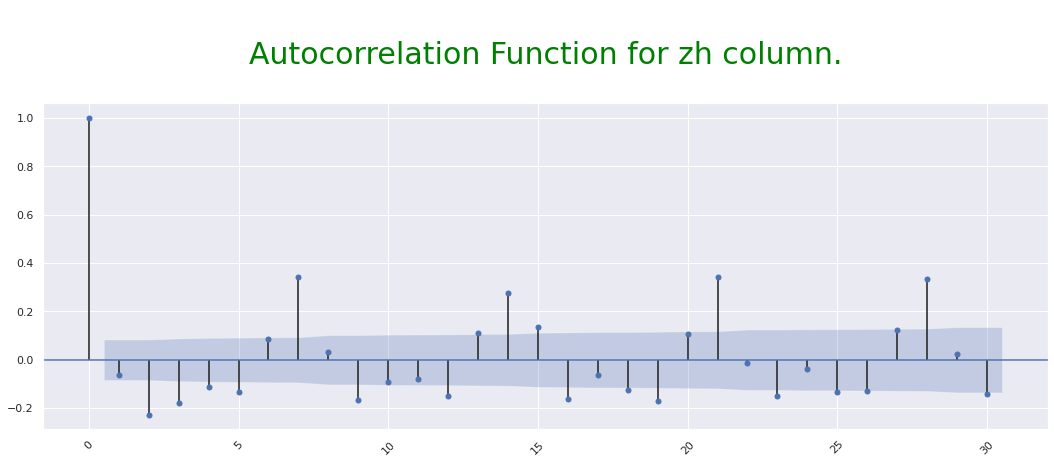

In [83]:
for column in df_diff.columns[1:]:
    fig, ax = plt.subplots(figsize=(18, 6))
    plot_acf(df_diff[column],lags=30, ax=ax, alpha=0.05)
    plt.xticks(rotation=45)
    plt.title(f"\nAutocorrelation Function for {column} column.\n", fontsize=30, color="green")
    plt.show()

***
***
## **14. Partial-Autocorrelation Function on all differentiated Time Series.**

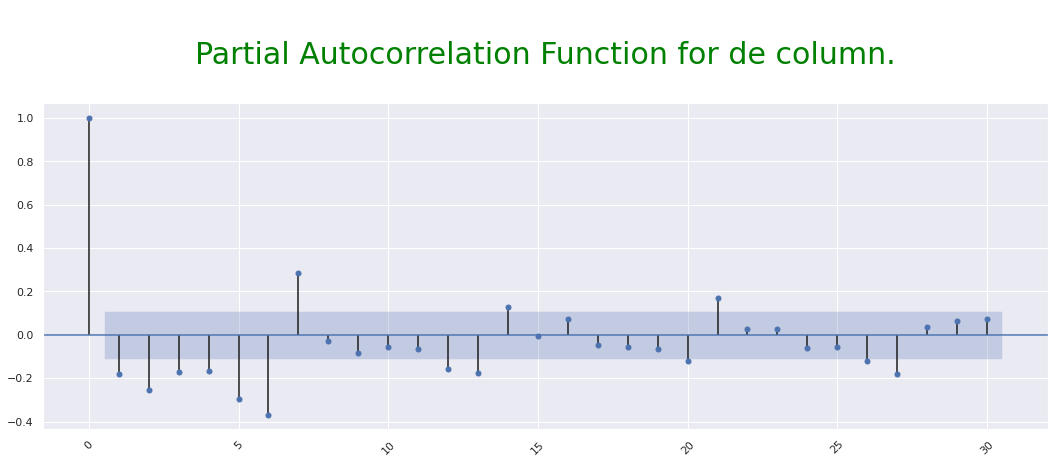

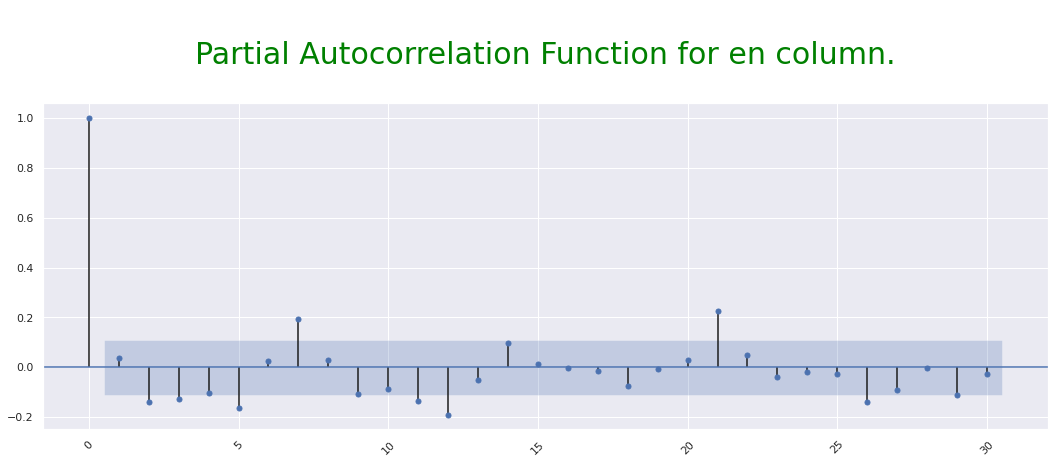

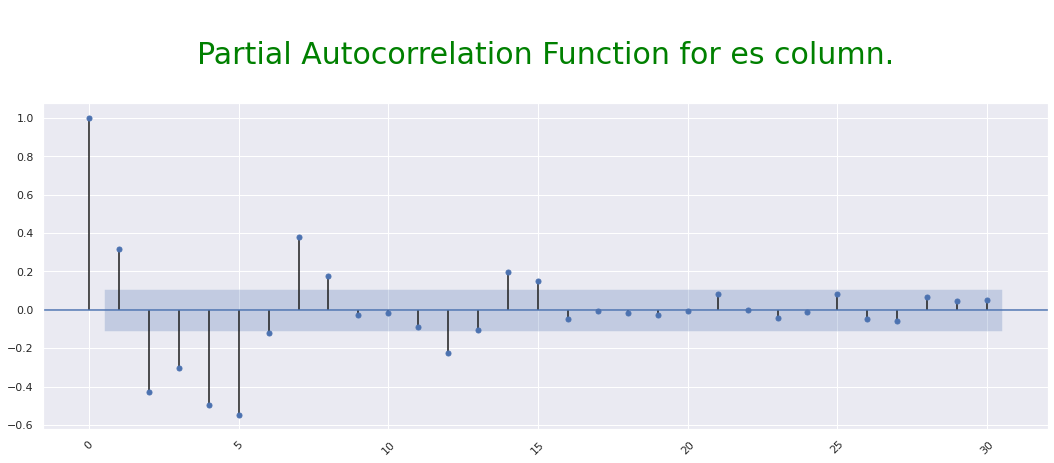

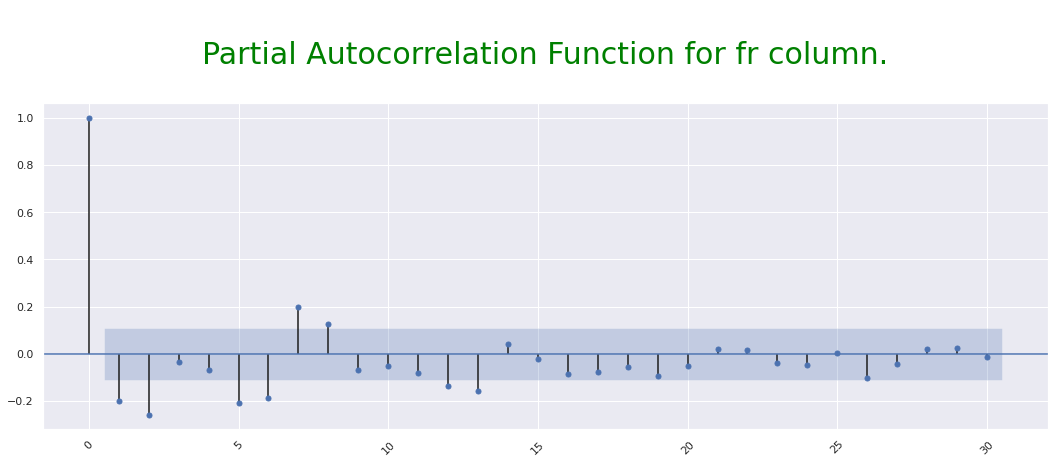

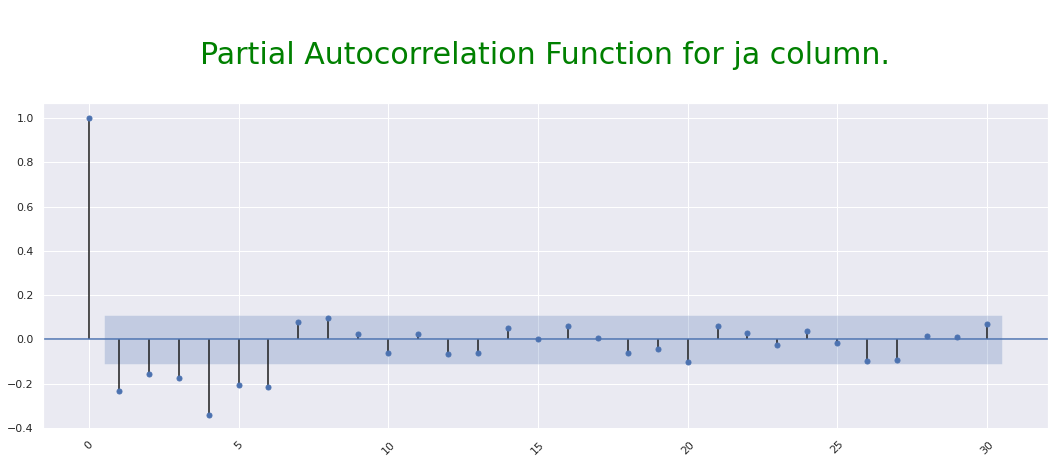

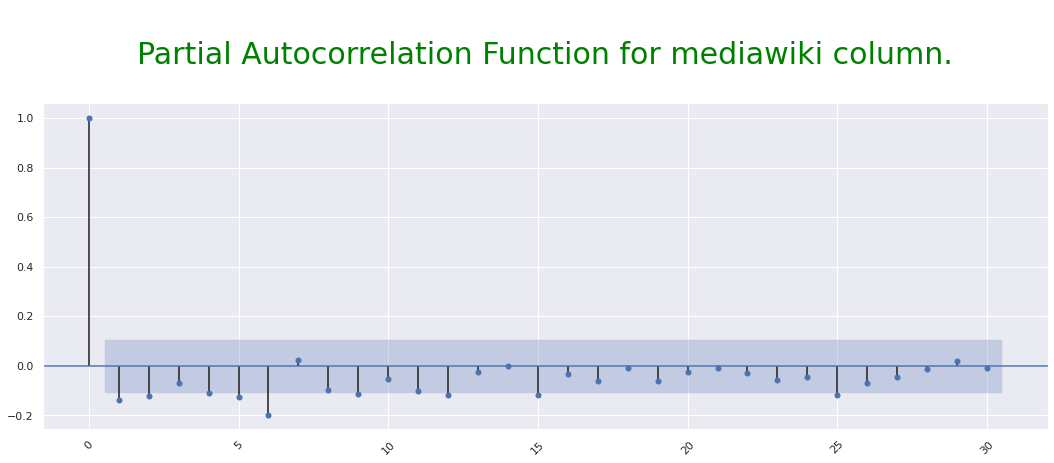

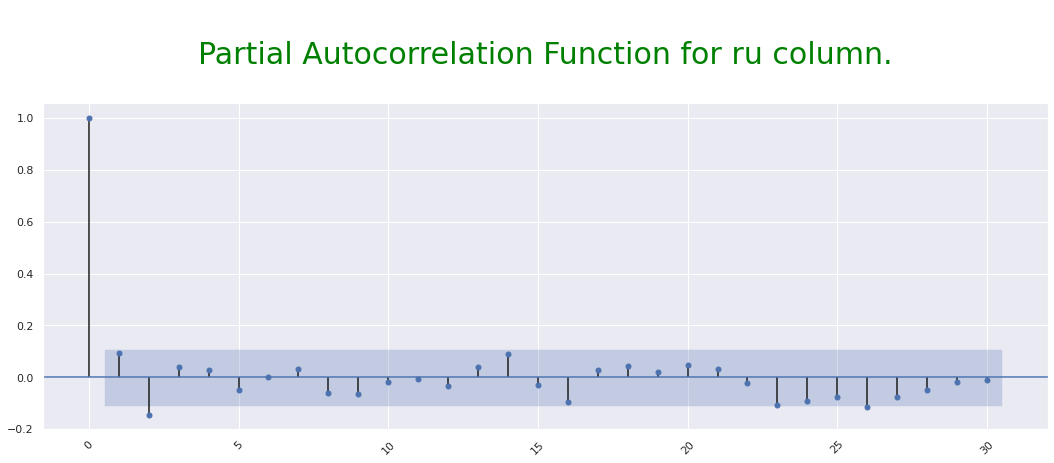

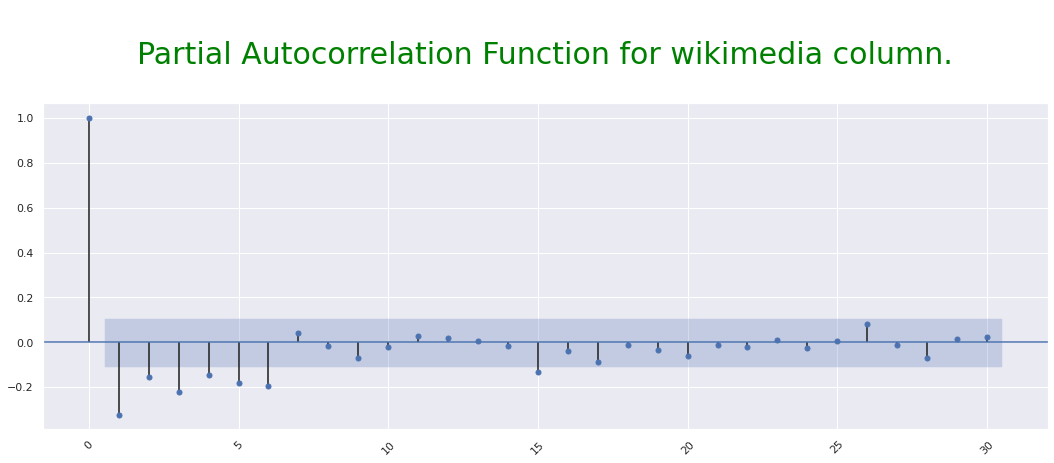

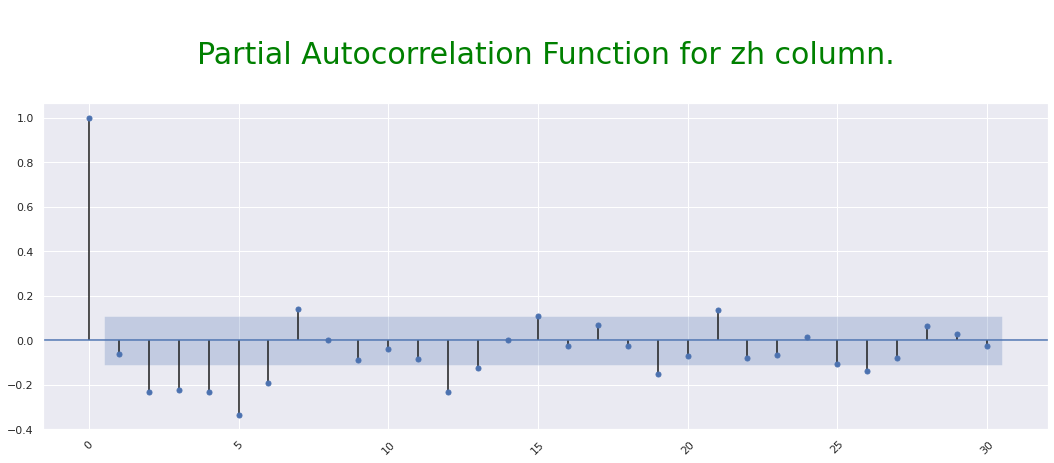

In [84]:
for column in df_diff.columns[1:]:
    fig, ax = plt.subplots(figsize=(18, 6))
    plot_pacf(df_diff[column],lags=30, ax=ax, alpha=0.01)
    plt.xticks(rotation=45)
    plt.title(f"\nPartial Autocorrelation Function for {column} column.\n", fontsize=30, color="green")
    plt.show()

***
***
## **15. ARIMA - Hyperparameter Tuning using custom Grid-Search function.**

In [86]:
for column in df_new.columns[1:]:
    pb, db, qb, mapeb = grid_search_arima(df_new, column=column, p_range=8, d_range=3, q_range=8)
    print(f"\n\nColumn: {column}\n")
    print(f"Best performing parameters are\np = {pb}\nd = {db}\nq = {qb}\nBest Mape Score = {mapeb}")



Column: de

Best performing parameters are
p = 7
d = 2
q = 7
Best Mape Score = 0.06560212888408687


Column: en

Best performing parameters are
p = 2
d = 2
q = 3
Best Mape Score = 0.0554562402644589


Column: es

Best performing parameters are
p = 2
d = 0
q = 2
Best Mape Score = 0.10698974267445822


Column: fr

Best performing parameters are
p = 7
d = 1
q = 7
Best Mape Score = 0.07361436738163155


Column: ja

Best performing parameters are
p = 5
d = 2
q = 7
Best Mape Score = 0.07417756279229641


Column: mediawiki

Best performing parameters are
p = 1
d = 0
q = 3
Best Mape Score = 0.1628615182710374


Column: ru

Best performing parameters are
p = 1
d = 2
q = 0
Best Mape Score = 0.05356621765985221


Column: wikimedia

Best performing parameters are
p = 4
d = 2
q = 1
Best Mape Score = 0.08966717225747664


Column: zh

Best performing parameters are
p = 5
d = 1
q = 6
Best Mape Score = 0.03135706598224089


***
***
## **15. ARIMA Forecast - on test data using tuned parameters.**

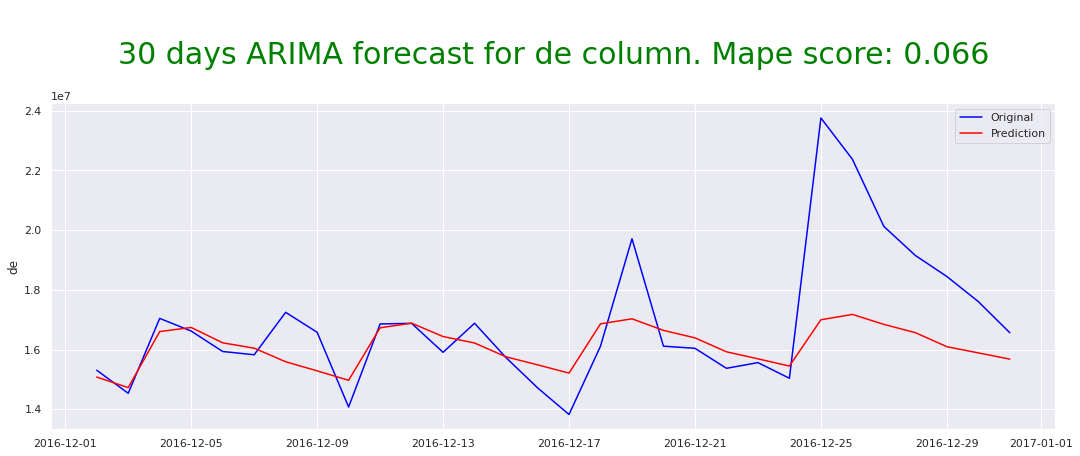

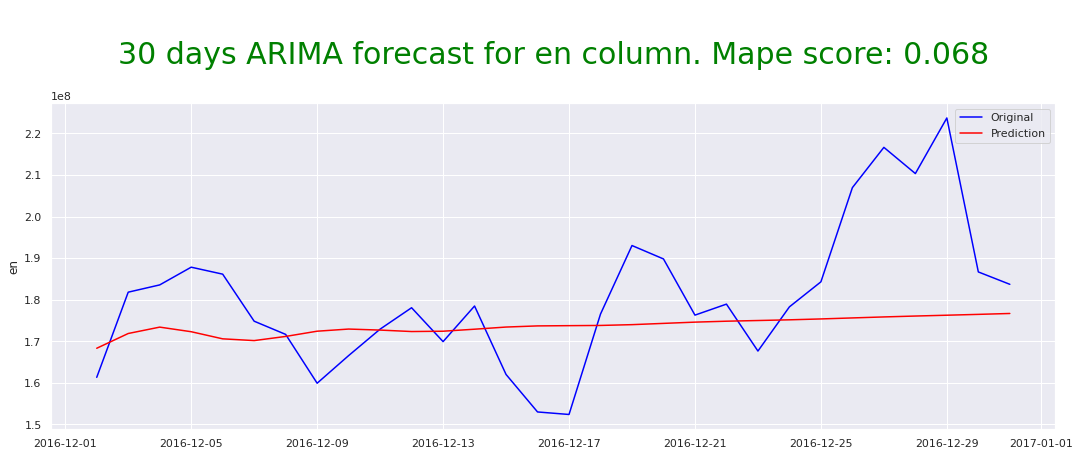

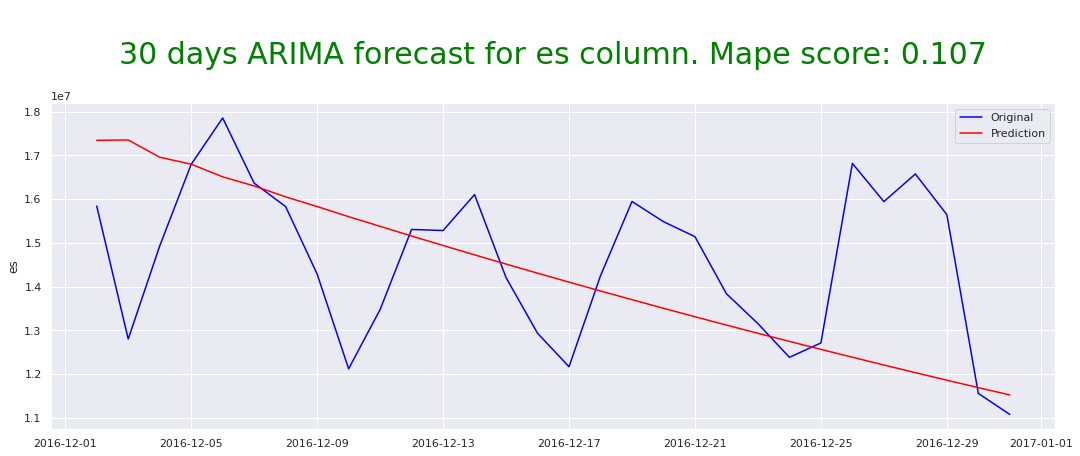

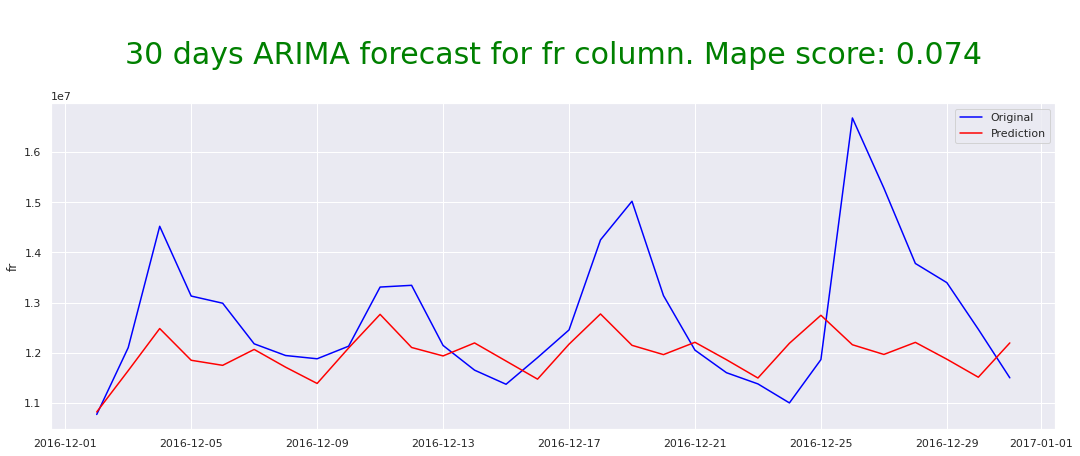

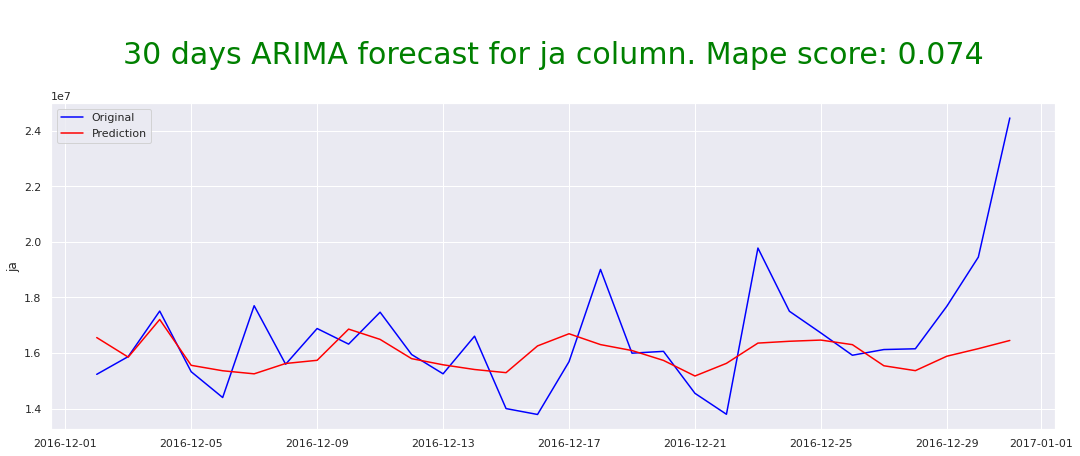

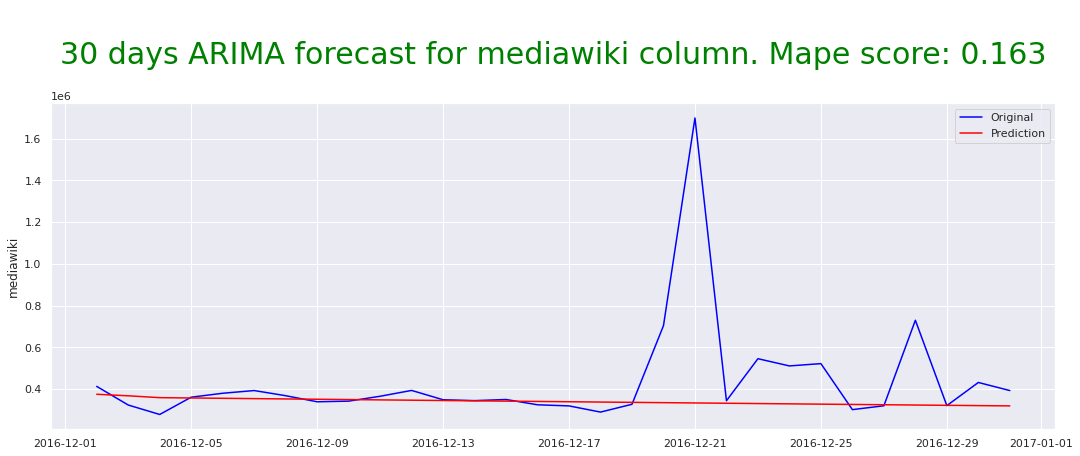

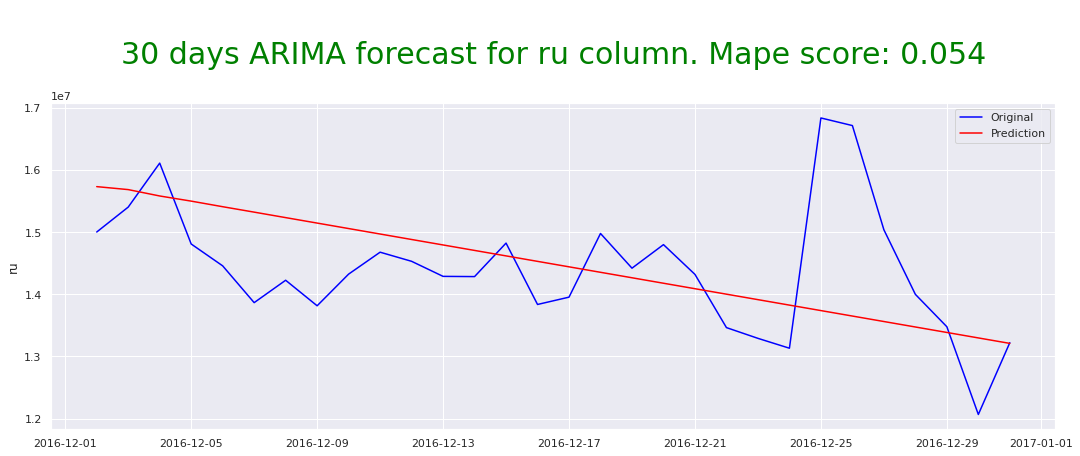

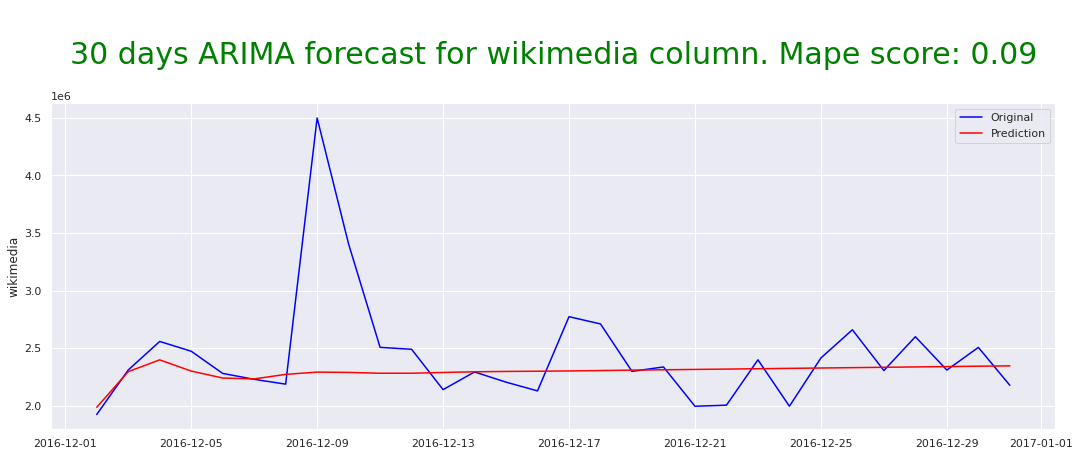

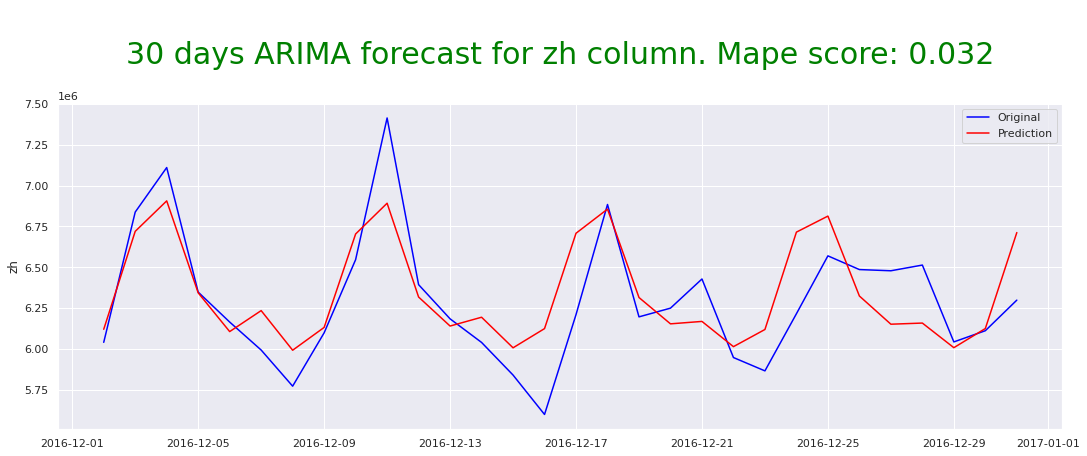

In [87]:
plot_arima(df_new, 'de', p=7, d=2, q=7)
plot_arima(df_new, 'en', p=2, d=2, q=5)
plot_arima(df_new, 'es', p=2, d=0, q=2)
plot_arima(df_new, 'fr', p=7, d=1, q=7)
plot_arima(df_new, 'ja', p=5, d=2, q=7)
plot_arima(df_new, 'mediawiki', p=1, d=0, q=3)
plot_arima(df_new, 'ru', p=1, d=2, q=0)
plot_arima(df_new, 'wikimedia', p=4, d=2, q=1)
plot_arima(df_new, 'zh', p=7, d=0, q=7)

***
***
## **15. SARIMAX Forecast - for English language pages.**

In [88]:
exog_df.index = df_new.index
exog_df.head()

Exog
2015-07-01     0
2015-07-02     0
2015-07-03     0
2015-07-04     0
2015-07-05     0

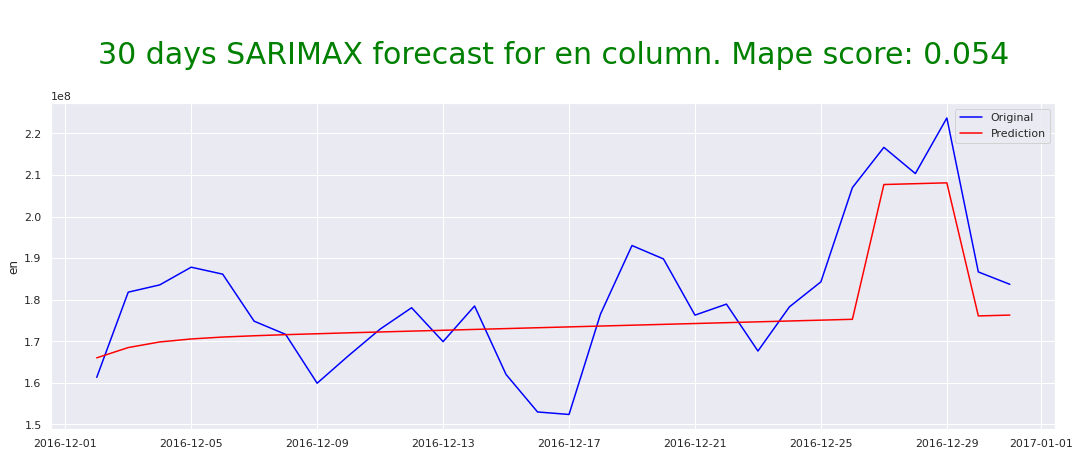

In [89]:
plot_sarimax(df_new, 'en', exog_df['Exog'], p=2, d=2, q=5, p2=0, d2=0, q2=0, m2=7)

***
***
## **15. FB Prophet Forecast - for English language pages.**

In [90]:
m = Prophet()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


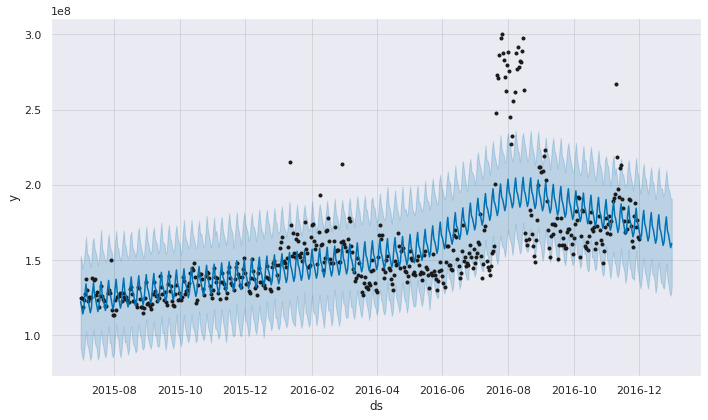

In [95]:
english = pd.DataFrame()
english['ds'] = df_new.index
english['y'] = df_new['en'].values
english[:-30]
m.fit(english[:-30]) #here we are leaving last 39 observations because we will predict it in 'future'
future = m.make_future_dataframe(periods=30,freq="D")
forecast = m.predict(future)
fig = m.plot(forecast)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


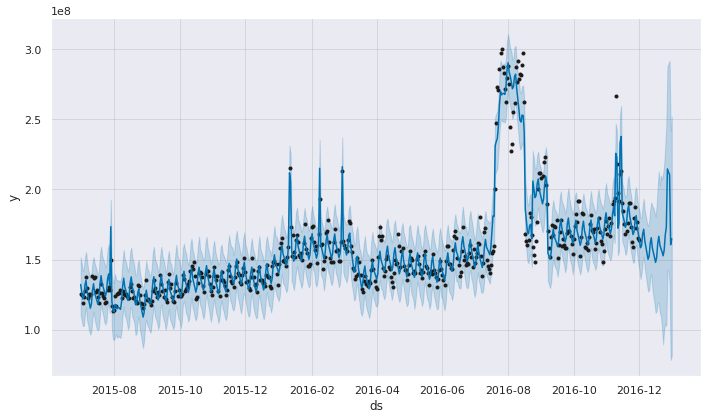

In [100]:
english = pd.DataFrame()
english['ds'] = df_new.index
english['y'] = df_new['en'].values
english['holiday'] = exog_df['Exog'].values
model2=Prophet(interval_width=0.95, yearly_seasonality=True, weekly_seasonality=True,changepoint_prior_scale=4)
model2.add_regressor('holiday') #adding holidays data in the model3
model2.fit(english[:-30])
forecast2 = model2.predict(english)
fig = model2.plot(forecast2)

In [108]:
mape_score = ((forecast2['yhat'].reset_index(drop=True)-df_new['en'].reset_index(drop=True))/df_new['en'].reset_index(drop=True)).abs().mean()

In [109]:
print(f"Mean Absolute Percentage Error achieved is {mape_score}")

Mean Absolute Percentage Error achieved is 0.04292787816736982


***
***
## **16. Making pipeline for ARIMA model.**

In [135]:
from sklearn.base import RegressorMixin, BaseEstimator
from sklearn.pipeline import make_pipeline

In [132]:
class custom_ARIMA(BaseEstimator, RegressorMixin):
    def __init__(self, p=1, d=1, q=1):
        self.p = p
        self.d = d
        self.q = q
        self.estimator = None
    def fit(self, X, y=None):
        model = SARIMAX(X, order=(self.p, self.d, self.q))
        self.estimator = model.fit(disp=False)
        return self
    def predict(self, X):
        days = len(X)
        return self.estimator.forecast(steps=days)
    def score(self, X, y=None):
        pred = self.predict(X)
        return round(mape(X, pred), 3)

In [ ]:
pipe = make_pipeline(custom_ARIMA(2, 2, 3))

***
***
## **17. Executing pipeline for English Time Series.**

In [142]:
pipe.fit(df_new['en'][:-30])

Pipeline(steps=[('custom_arima', custom_ARIMA(d=2, p=2, q=3))])

In [144]:
pipe.score(df_new['en'][-30:])

0.082

***
***
## **18. Business Insights and Recommendations.**
#### **A.** More than 70k pages have access type as all-access, 35k pages have desktop and mobile each.
#### **B.** More than 110k pages have agent type as all-agent, 35k pages have spider as agent type.
#### **C.** Most number of pages arein English followed by Japanese and German.
#### **D.** Top 5 most popular Wikipedia pages include topics such as, 404 Error in php code, Former POTUS - Donald_Trump and Adult Website - XHamster.
#### **E.** Without differencing, time series for Spanish, French, Russian, Mediawiki and wikimedia are stationary. Rest all are non stationary.
#### **F.** After differencing only once, all Time Series became stationary.
#### **G.** ACF and PACF on differentiated series shows primary periodicity of 7 days.
#### **H.** Best performance using ARIMA model was achieved for Chinese Time Series with MAPE score of just 3.2%
#### **I.** Using SARIMAX with an exogenous variable on English time series, reduced MAPE error from 6.8% to 5.4%
#### **J.** FB Prophet could achieve the best performance for English time series with MAPE score of just 4.2%.
#### **K.** Since using exogenous variable with English Time series proved to be successful method for reducing prediction error, we can also incorporate this strategy for other languages.
#### **K.** Adease can devise a language based strategy, where more ads can be placed on pages when the view count is forecasted to increase for the pages in that language.